In [1]:
#The code that inputs all videos and creates a CSV file of position of the hand

import cv2 as cv
import matplotlib.pyplot as plt
import csv
from csv import writer

net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

inWidth = 368
inHeight = 368
inScale = 1

thr = 0.2

BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
              ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
              ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]]

#Import image

#img = cv.imread("pose.png")
#plt.imshow(img)
#plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))


def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    inp = cv.dnn.blobFromImage(frame, inScale, (inWidth, inHeight),
                               (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inp)
    out = net.forward()

    assert (len(BODY_PARTS) <= out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert (partFrom in BODY_PARTS)
        assert (partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame



#estimated_image = pose_estimation(img)
#plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))

#Video
vidcoordinates = []

vidvalue = []
vidnames=[]
namessubjects = ['Marcus','Andrei','Elsa','Nathalie','Oskar','Viktor']
for i in range(4):
    for j in namessubjects:
        for k in range(10):
                vidvalue.append(i)
                vidnames.append(f'Armpares {i} - {j} - {k+1}.mp4')
#vidnamess = ['Pares i arm right 3 - 1080 50fps - 1_Trim.mp4', 'Pares i arm right 3 - 1080 50fps - 2_Trim.mp4']
#vidnamess = ['nataliepeka1_1_20.mp4', 'nataliepeka1_4_20.mp4']
for i in vidnames:
    print(i)
    allpointsright =[]
    allpointsleft = []
    allpoints = []
    cap = cv.VideoCapture(i)
    cap.set(3, 800)
    cap.set(4, 800)

    if not cap.isOpened():
        cap = cv.VideoCapture(0)
    if not cap.isOpened():
        raise IOError('Cannot open video')
    while cv.waitKey(1) < 0:
        hasFrame, frame = cap.read()
        if not hasFrame:
            cv.waitKey()
            break
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        inp = cv.dnn.blobFromImage(frame, inScale, (inWidth, inHeight),
                                   (0, 0, 0), swapRB=False, crop=False)
        net.setInput(inp)
        out = net.forward()

        assert (len(BODY_PARTS) <= out.shape[1])

        points = []
        for i in range(len(BODY_PARTS)):
            # Slice heatmap of corresponding body's part.
            heatMap = out[0, i, :, :]

            # Originally, we try to find all the local maximums. To simplify a sample
            # we just find a global one. However only a single pose at the same time
            # could be detected this way.
            _, conf, _, point = cv.minMaxLoc(heatMap)
            x = (frameWidth * point[0]) / out.shape[3]
            y = (frameHeight * point[1]) / out.shape[2]

            # Add a point if it's confidence is higher than threshold.
            points.append((int(x), int(y)) if conf > thr else None)

        for pair in POSE_PAIRS:
            partFrom = pair[0]
            partTo = pair[1]
            assert (partFrom in BODY_PARTS)
            assert (partTo in BODY_PARTS)

            idFrom = BODY_PARTS[partFrom]
            idTo = BODY_PARTS[partTo]

            if points[idFrom] and points[idTo]:
                cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
                cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
                cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

        t, _ = net.getPerfProfile()
        freq = cv.getTickFrequency() / 2000
        cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
        #print(points)
        #cv.imshow('Pose estimation Tutorial', frame)
        
        if points[4] is not None:
            allpointsright.append(points[4][1]/1080)
        if points[7] is not None:
            allpointsleft.append(points[7][1]/1080)
    if min(allpointsright) < min(allpointsleft):
        #vidcoordinates.append(allpointsright)
        with open('vidcoordinates.csv', 'a') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(allpointsright)
            f_object.close()
        print('right')
        #print(allpointsright)
    elif min(allpointsright) > min(allpointsleft):
        #vidcoordinates.append(allpointsleft)
        with open('vidcoordinates.csv', 'a') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(allpointsleft)
            f_object.close()
        print('left')
        #print(allpointsleft)
    
#print(vidcoordinates)


Armpares 0 - Marcus - 1.mp4
right
Armpares 0 - Marcus - 2.mp4
right
Armpares 0 - Marcus - 3.mp4
right
Armpares 0 - Marcus - 4.mp4
right
Armpares 0 - Marcus - 5.mp4
right
Armpares 0 - Marcus - 6.mp4
left
Armpares 0 - Marcus - 7.mp4
left
Armpares 0 - Marcus - 8.mp4
left
Armpares 0 - Marcus - 9.mp4
left
Armpares 0 - Marcus - 10.mp4
left
Armpares 0 - Andrei - 1.mp4
left
Armpares 0 - Andrei - 2.mp4
right
Armpares 0 - Andrei - 3.mp4
right
Armpares 0 - Andrei - 4.mp4
right
Armpares 0 - Andrei - 5.mp4
right
Armpares 0 - Andrei - 6.mp4
right
Armpares 0 - Andrei - 7.mp4
left
Armpares 0 - Andrei - 8.mp4
left
Armpares 0 - Andrei - 9.mp4
left
Armpares 0 - Andrei - 10.mp4
left
Armpares 0 - Elsa - 1.mp4
left
Armpares 0 - Elsa - 2.mp4
right
Armpares 0 - Elsa - 3.mp4
right
Armpares 0 - Elsa - 4.mp4
right
Armpares 0 - Elsa - 5.mp4
right
Armpares 0 - Elsa - 6.mp4
right
Armpares 0 - Elsa - 7.mp4
left
Armpares 0 - Elsa - 8.mp4
left
Armpares 0 - Elsa - 9.mp4
left
Armpares 0 - Elsa - 10.mp4
left
Armpares 0 -

In [1]:
#From csv to list
#Börja med att köra denna när du har 'vidcoordinates.csv' i samma mapp som denna fil

import csv
import cv2 as cv
import matplotlib.pyplot as plt
import csv
from csv import writer

with open('vidcoordinates.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

newbetterlist = []
for i in data:
    if i:
        newbetterlist.append(i)
print(newbetterlist)

[['0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5425925925925926', '0.5212962962962963', '0.52129

In [2]:
vidvalue = []
namessubjects = ['Marcus','Andrei','Elsa','Nathalie','Oskar','Viktor']
for i in range(4):
    for j in namessubjects:
        for k in range(10):
                vidvalue.append(i)
print(vidvalue)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [3]:
vidvaluebi = []
namessubjects = ['Marcus','Andrei','Elsa','Nathalie','Oskar','Viktor']
for i in range(4):
    for j in namessubjects:
        for k in range(10):
            vidvaluebi.append(i)
for i in range(len(vidvaluebi)):
    if vidvaluebi[i] != 0:
        vidvaluebi[i]=1
print(vidvaluebi)
print(len(vidvaluebi))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
240


In [4]:
vidcoordinates = newbetterlist

In [5]:
#Make strings into ints

for i in range(len(vidcoordinates)):
    for j in range(len(vidcoordinates[i])):
        vidcoordinates[i][j] = float(vidcoordinates[i][j])
print(vidcoordinates)

[[0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5425925925925926, 0.5212962962962963, 0.5212962962962963, 0.5212962962962963, 0.5212962962962963, 0.5212962962962963, 0.5212962962962963

In [6]:
#Append zeros to make the same size
lengths = []
for i in vidcoordinates:
    lengths.append(len(i))
print(lengths)
print(max(lengths))

for i in vidcoordinates:
    while len(i) < max(lengths):
        i.append(0)
print(vidcoordinates)

[751, 672, 633, 683, 594, 586, 589, 582, 283, 488, 523, 525, 551, 545, 492, 465, 517, 524, 524, 538, 419, 534, 531, 504, 512, 540, 489, 504, 465, 441, 506, 495, 515, 531, 502, 460, 148, 178, 162, 72, 564, 569, 609, 615, 572, 572, 562, 563, 565, 575, 524, 532, 504, 511, 511, 491, 555, 529, 585, 568, 635, 605, 616, 598, 605, 553, 571, 574, 560, 618, 518, 543, 568, 557, 556, 608, 543, 527, 539, 539, 501, 523, 530, 481, 530, 513, 470, 536, 534, 543, 502, 585, 500, 506, 513, 524, 496, 474, 521, 508, 559, 614, 623, 551, 570, 637, 554, 551, 582, 589, 562, 588, 575, 566, 565, 567, 586, 558, 561, 529, 652, 579, 585, 680, 565, 529, 554, 547, 597, 535, 555, 586, 609, 570, 567, 604, 531, 562, 649, 554, 594, 558, 594, 595, 569, 612, 564, 573, 557, 577, 509, 515, 520, 511, 511, 519, 523, 542, 500, 500, 554, 607, 567, 524, 611, 546, 601, 573, 566, 581, 553, 579, 576, 578, 547, 557, 564, 549, 560, 575, 496, 375, 412, 399, 418, 386, 390, 375, 353, 374, 393, 374, 531, 381, 459, 505, 459, 398, 479, 430, 

In [17]:
print(len(vidcoordinates),len(vidvalue))

240 240


0


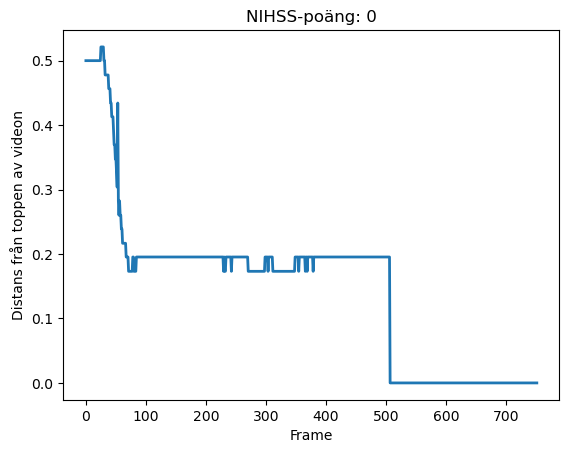

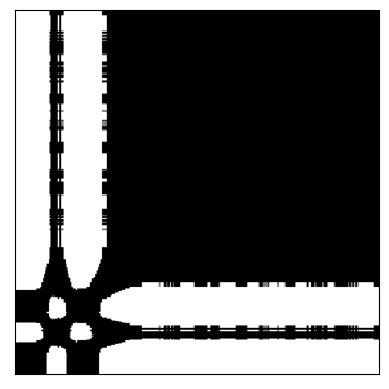

(1, 751, 751)


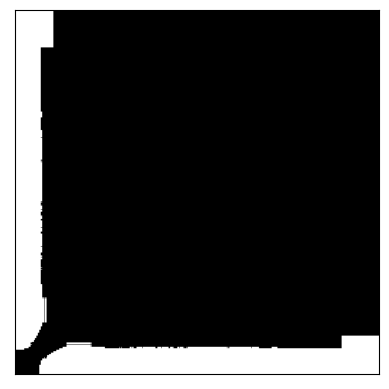

(1, 751, 751)


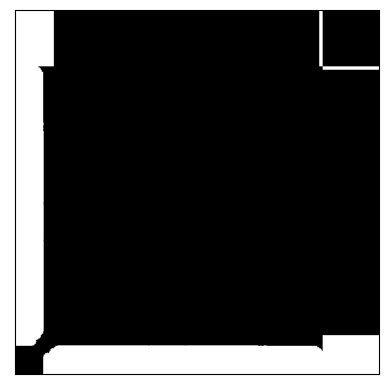

(1, 751, 751)


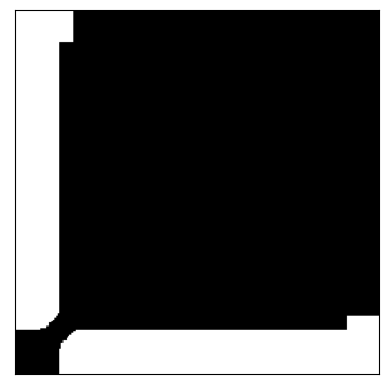

(1, 751, 751)


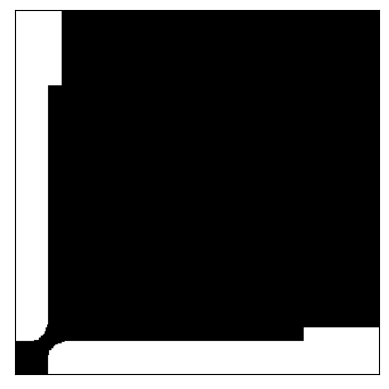

(1, 751, 751)


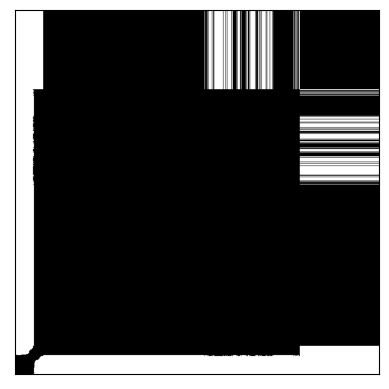

(1, 751, 751)


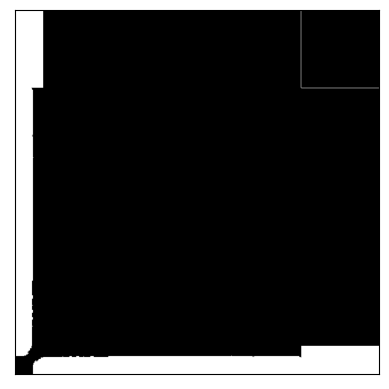

(1, 751, 751)


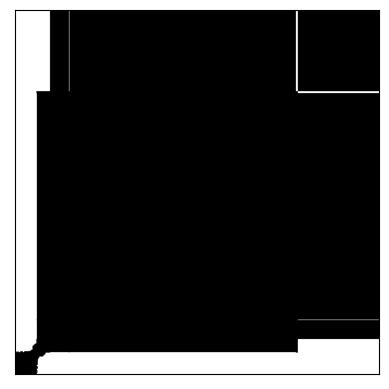

(1, 751, 751)


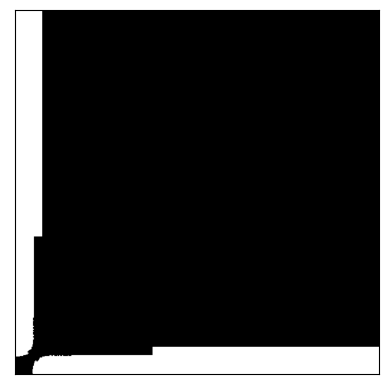

(1, 751, 751)


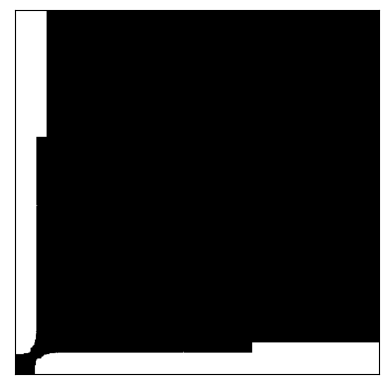

(1, 751, 751)


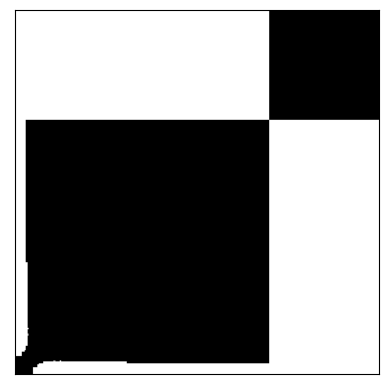

(1, 751, 751)


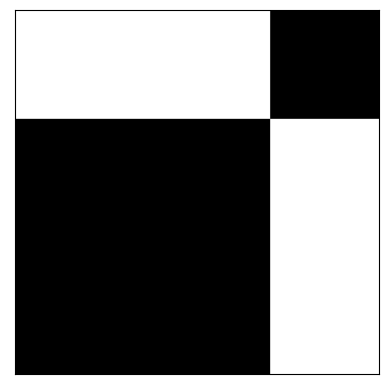

(1, 751, 751)


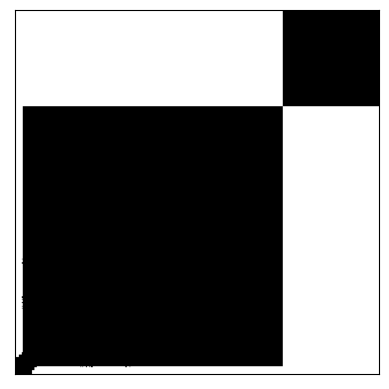

(1, 751, 751)


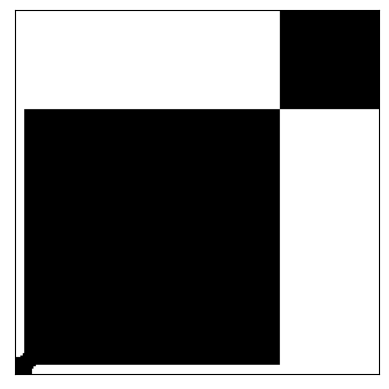

(1, 751, 751)


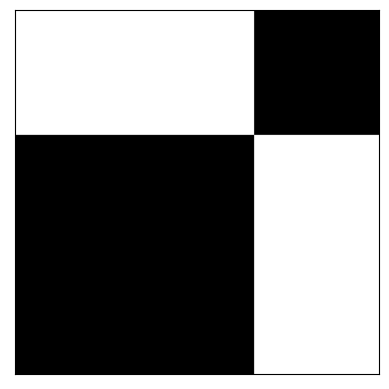

(1, 751, 751)


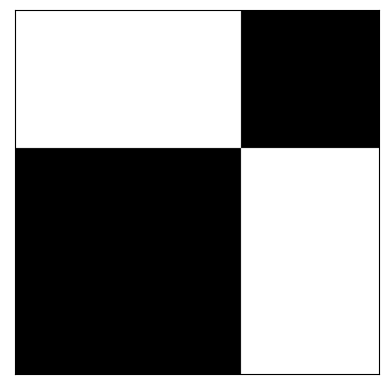

(1, 751, 751)


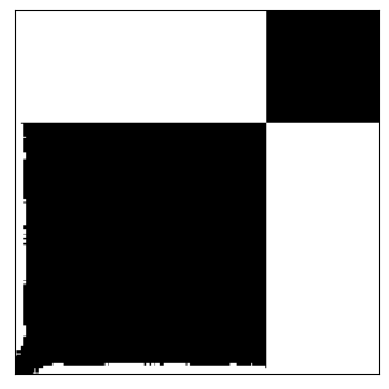

(1, 751, 751)


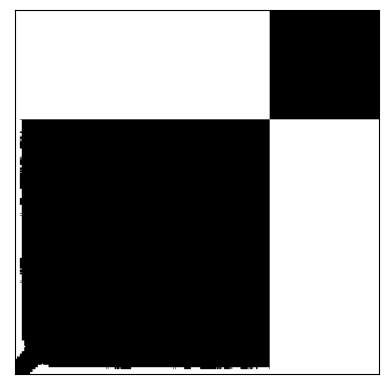

(1, 751, 751)


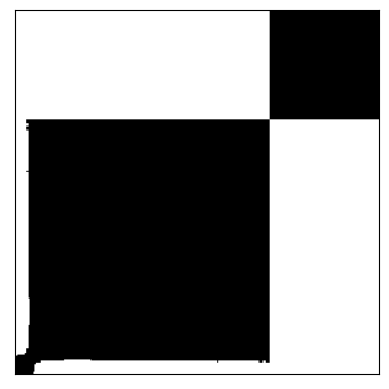

(1, 751, 751)


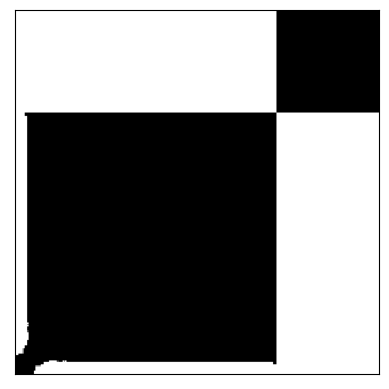

(1, 751, 751)


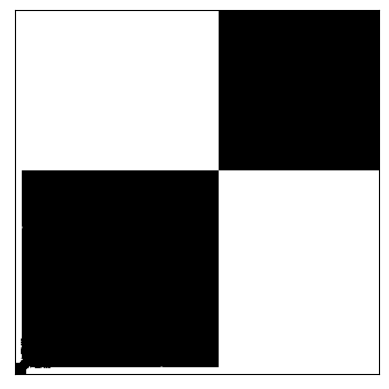

(1, 751, 751)


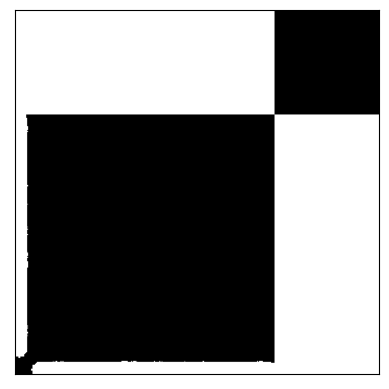

(1, 751, 751)


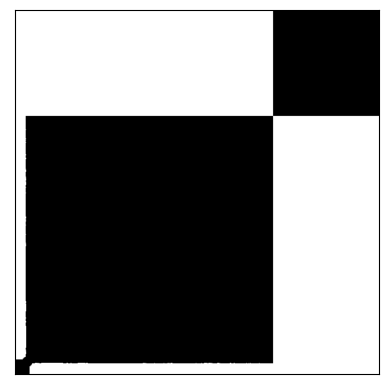

(1, 751, 751)


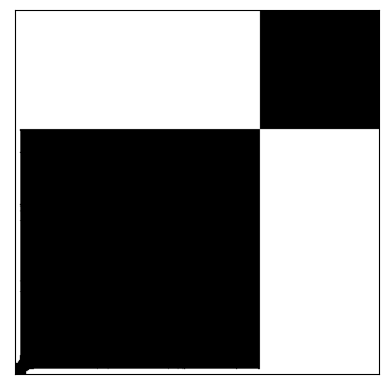

(1, 751, 751)


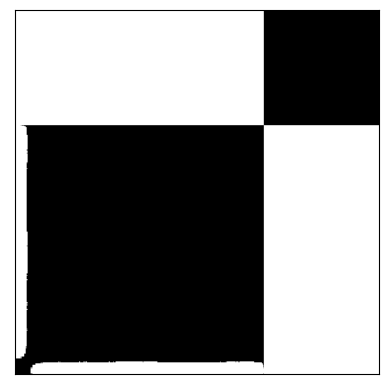

(1, 751, 751)


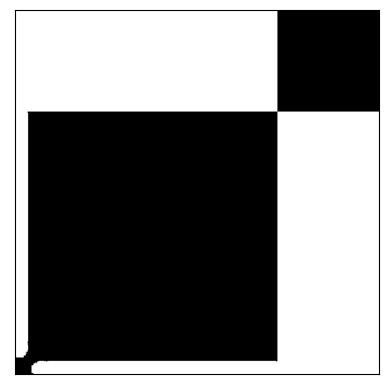

(1, 751, 751)


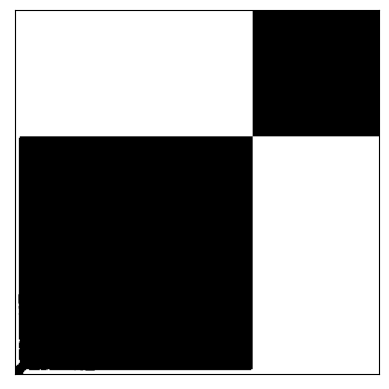

(1, 751, 751)


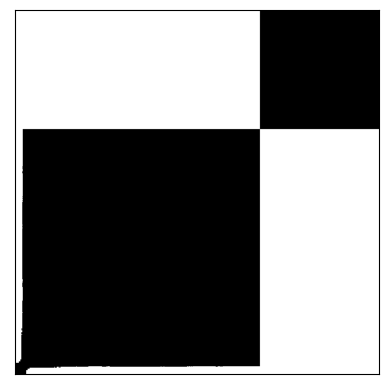

(1, 751, 751)


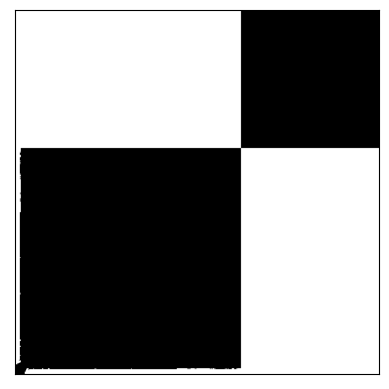

(1, 751, 751)


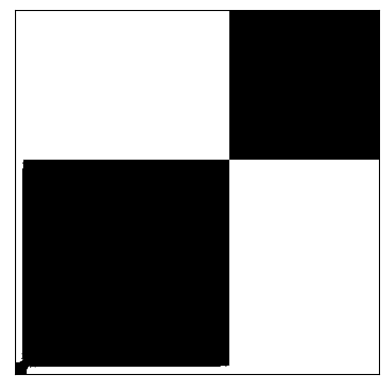

(1, 751, 751)


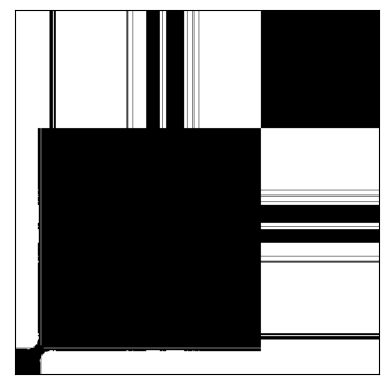

(1, 751, 751)


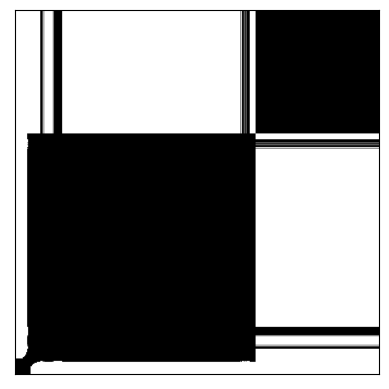

(1, 751, 751)


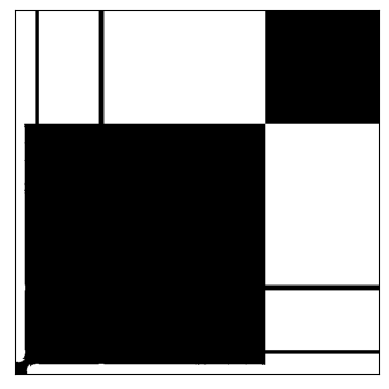

(1, 751, 751)


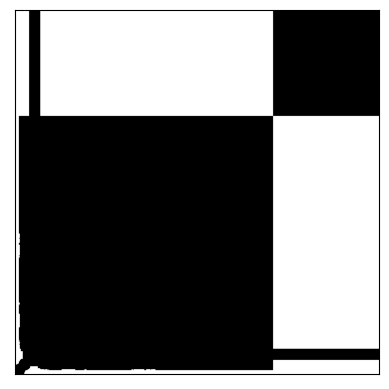

(1, 751, 751)


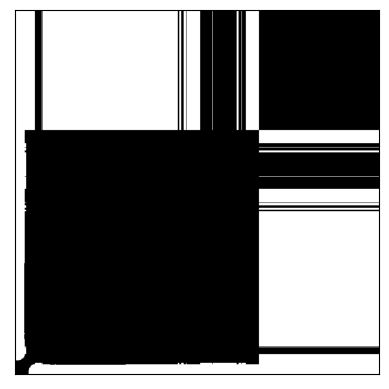

(1, 751, 751)


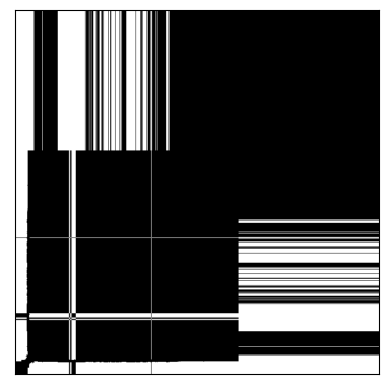

(1, 751, 751)


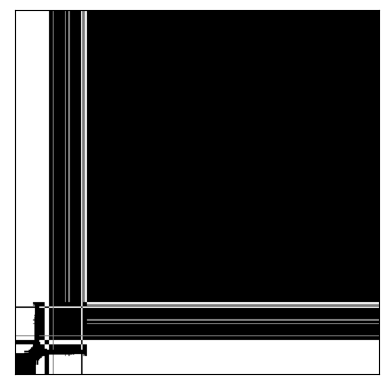

(1, 751, 751)


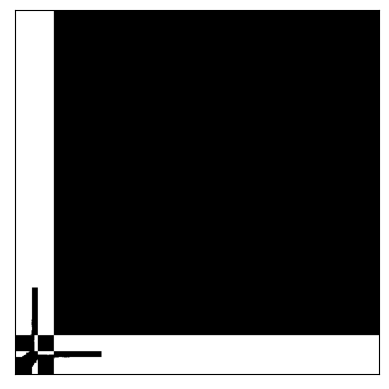

(1, 751, 751)


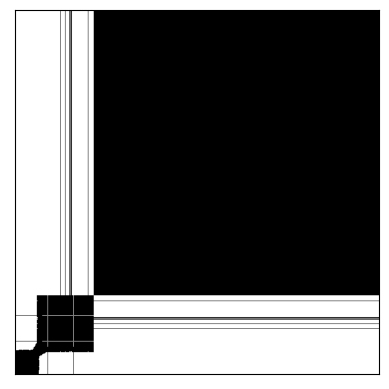

(1, 751, 751)


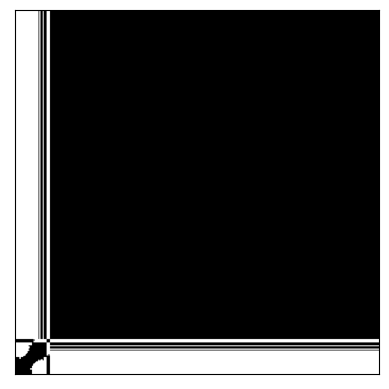

(1, 751, 751)


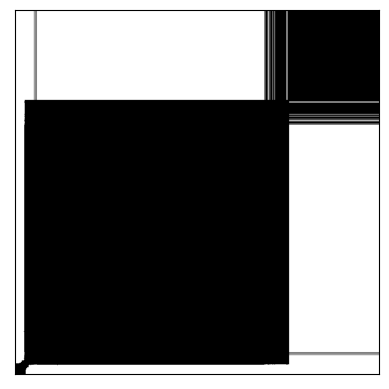

(1, 751, 751)


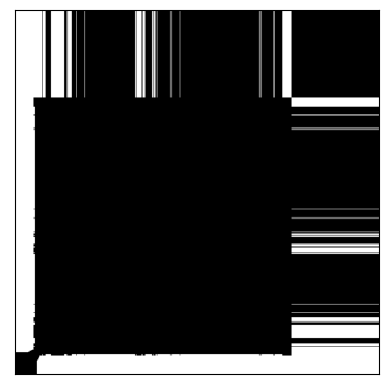

(1, 751, 751)


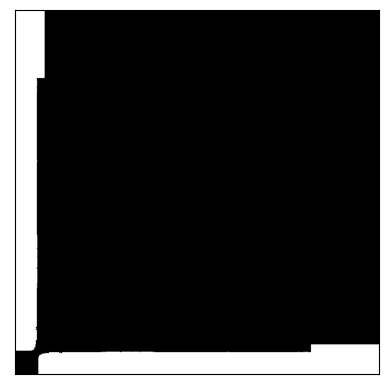

(1, 751, 751)


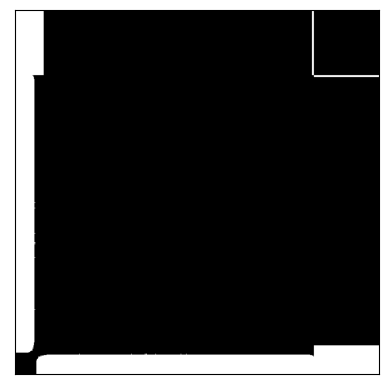

(1, 751, 751)


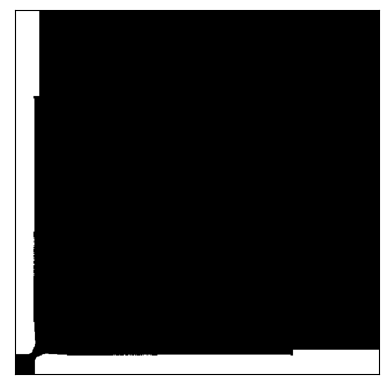

(1, 751, 751)


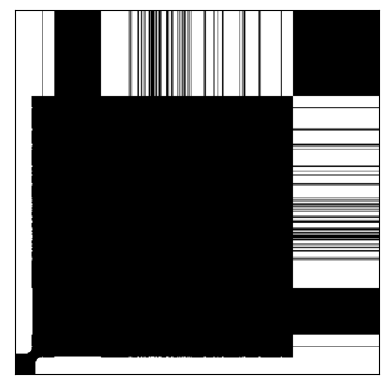

(1, 751, 751)


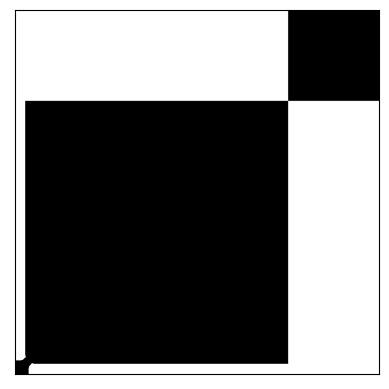

(1, 751, 751)


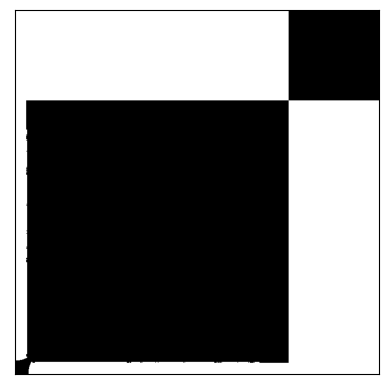

(1, 751, 751)


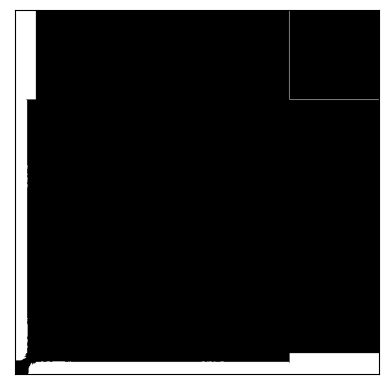

(1, 751, 751)


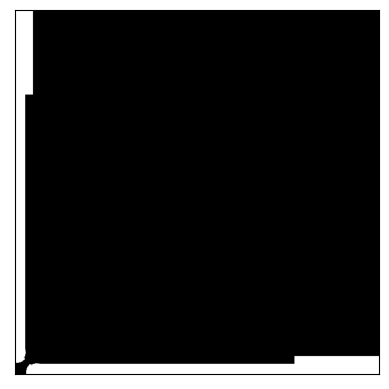

(1, 751, 751)


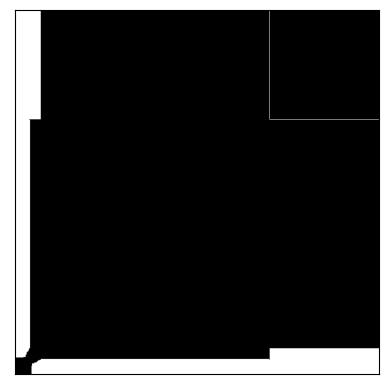

(1, 751, 751)


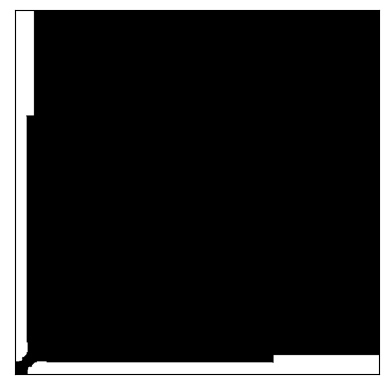

(1, 751, 751)


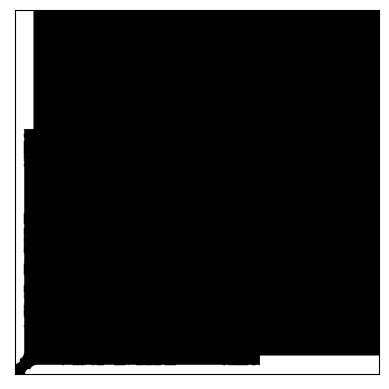

(1, 751, 751)


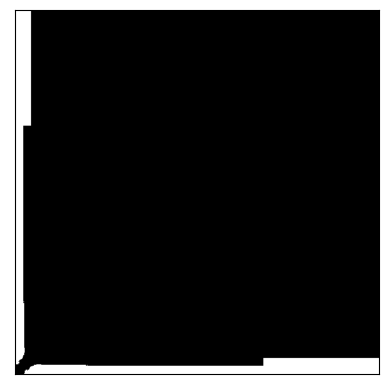

(1, 751, 751)


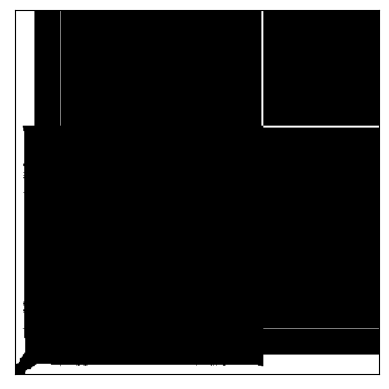

(1, 751, 751)


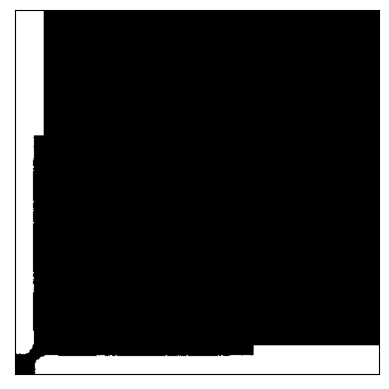

(1, 751, 751)


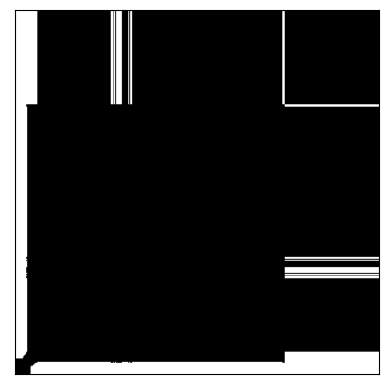

(1, 751, 751)


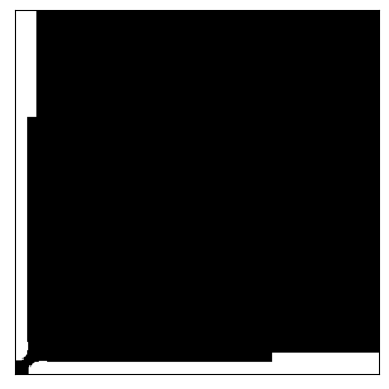

(1, 751, 751)


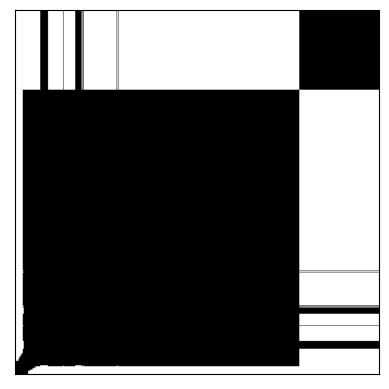

(1, 751, 751)


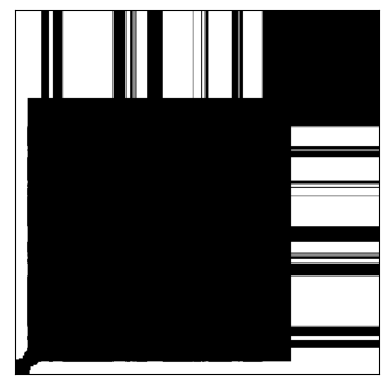

(1, 751, 751)


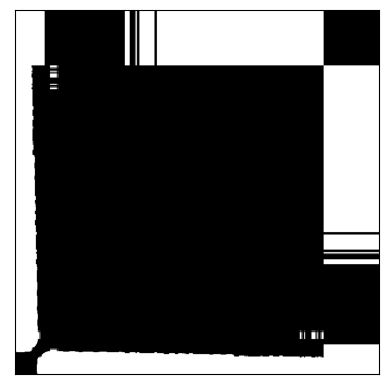

(1, 751, 751)


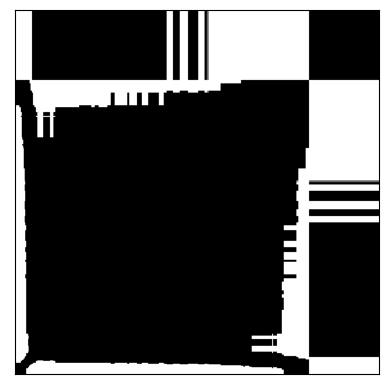

(1, 751, 751)


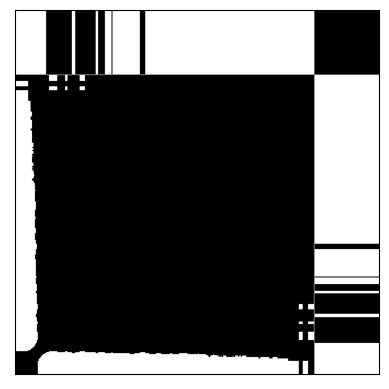

(1, 751, 751)


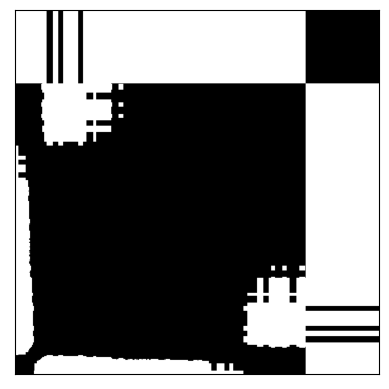

(1, 751, 751)


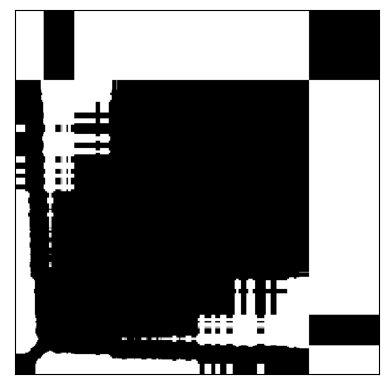

(1, 751, 751)


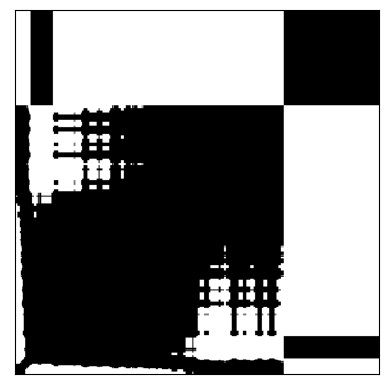

(1, 751, 751)


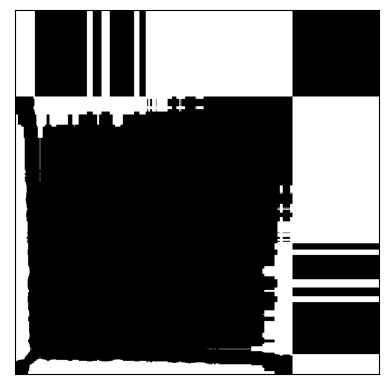

(1, 751, 751)


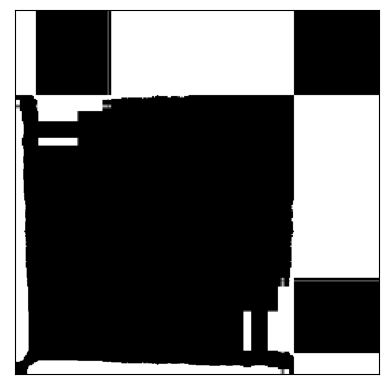

(1, 751, 751)


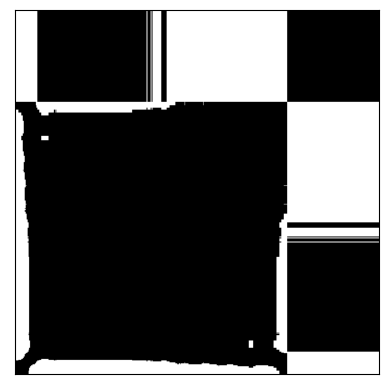

(1, 751, 751)


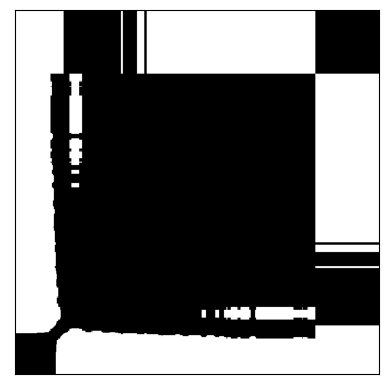

(1, 751, 751)


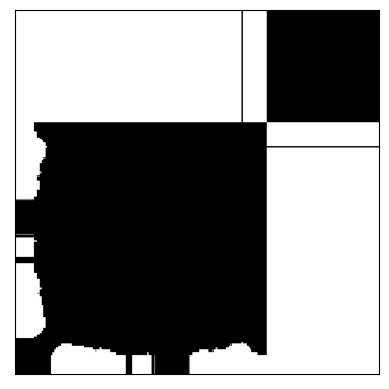

(1, 751, 751)


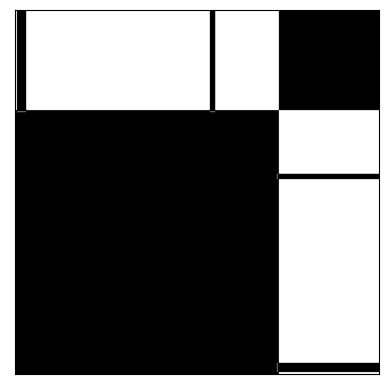

(1, 751, 751)


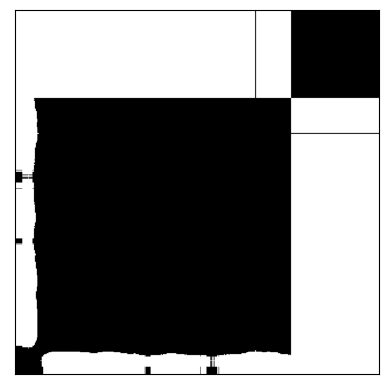

(1, 751, 751)


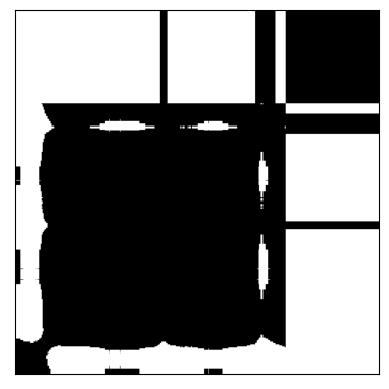

(1, 751, 751)


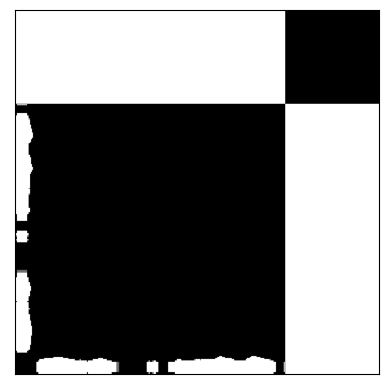

(1, 751, 751)


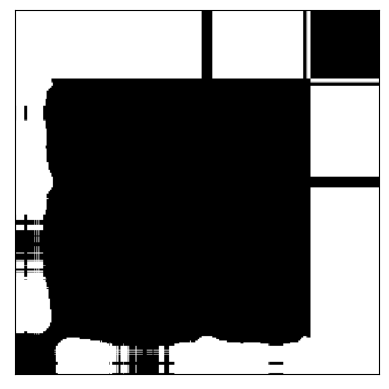

(1, 751, 751)


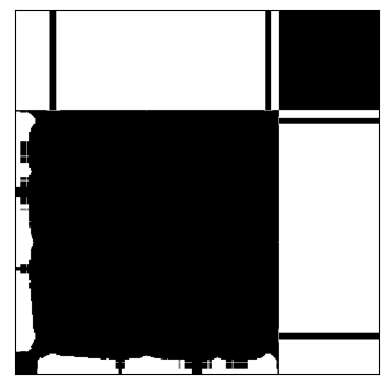

(1, 751, 751)


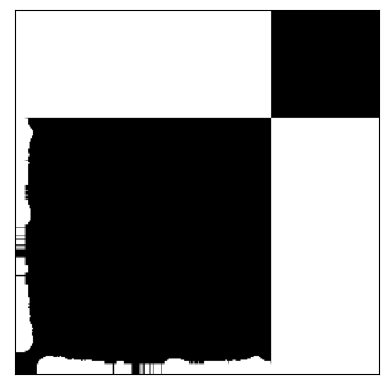

(1, 751, 751)


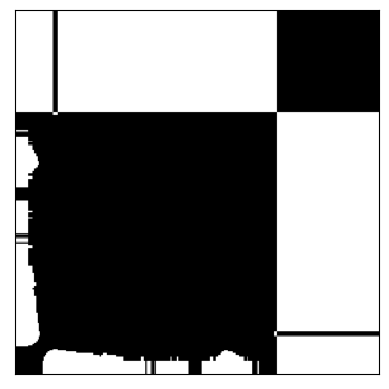

(1, 751, 751)


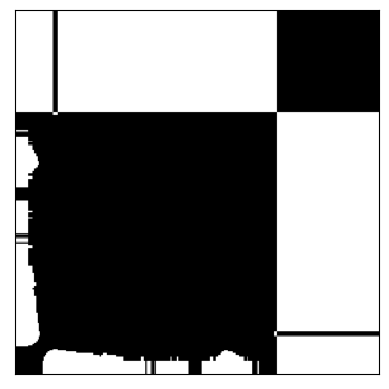

(1, 751, 751)


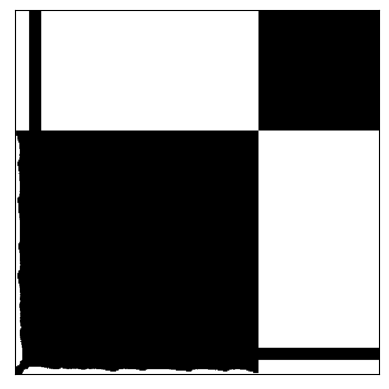

(1, 751, 751)


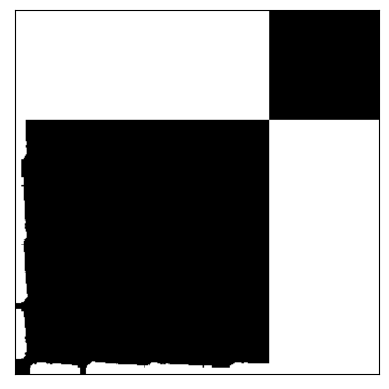

(1, 751, 751)


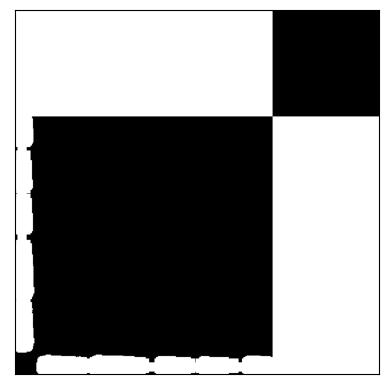

(1, 751, 751)


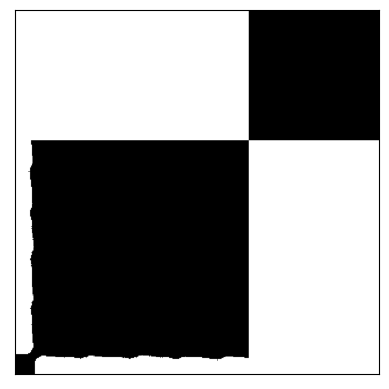

(1, 751, 751)


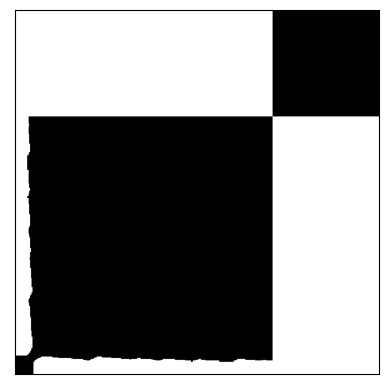

(1, 751, 751)


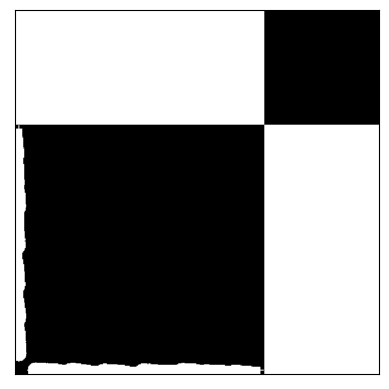

(1, 751, 751)


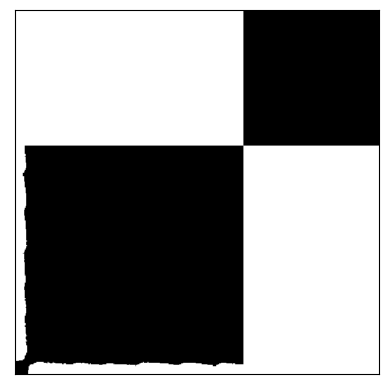

(1, 751, 751)


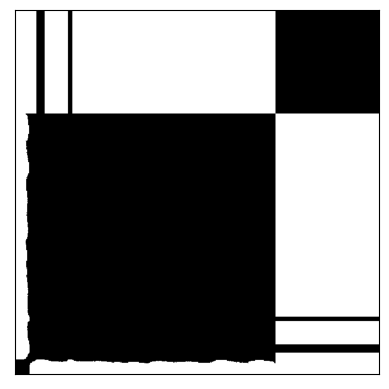

(1, 751, 751)


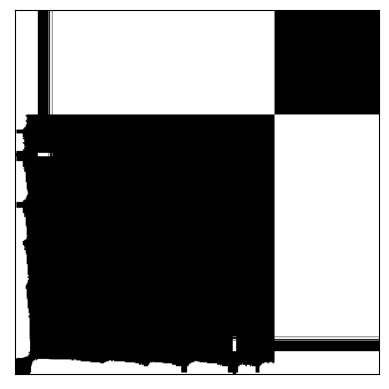

(1, 751, 751)


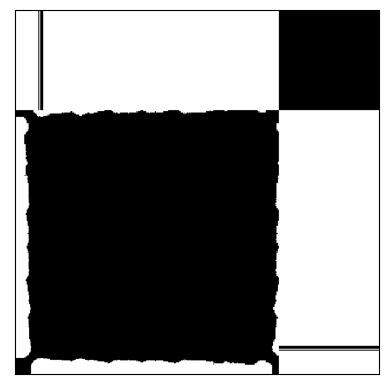

(1, 751, 751)


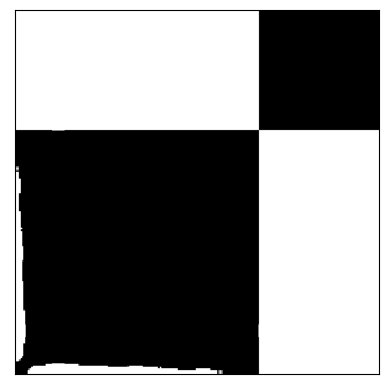

(1, 751, 751)


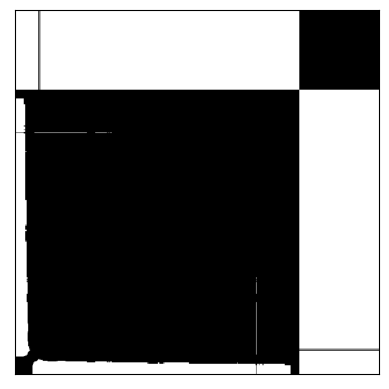

(1, 751, 751)


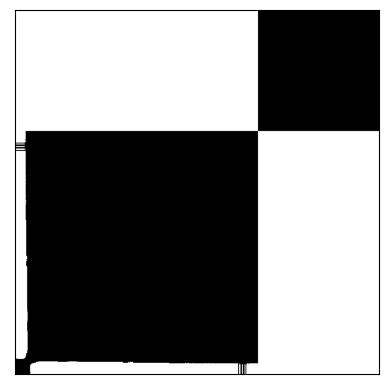

(1, 751, 751)


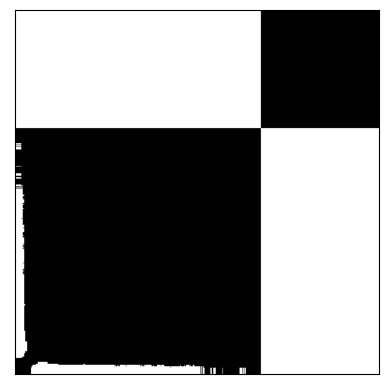

(1, 751, 751)


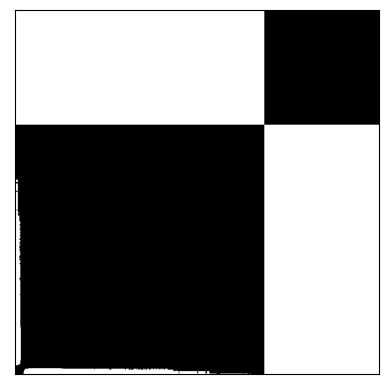

(1, 751, 751)


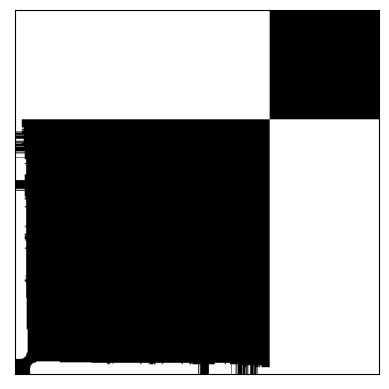

(1, 751, 751)


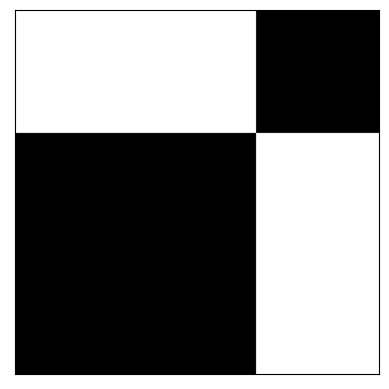

(1, 751, 751)


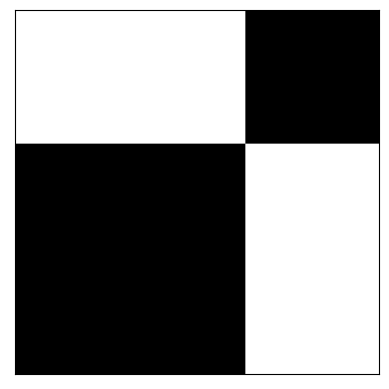

(1, 751, 751)


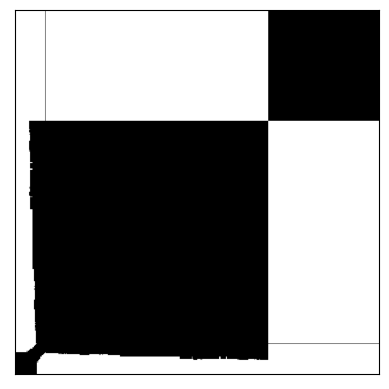

(1, 751, 751)


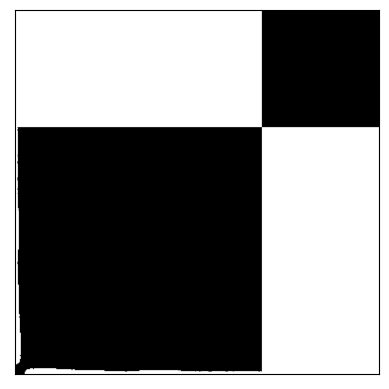

(1, 751, 751)


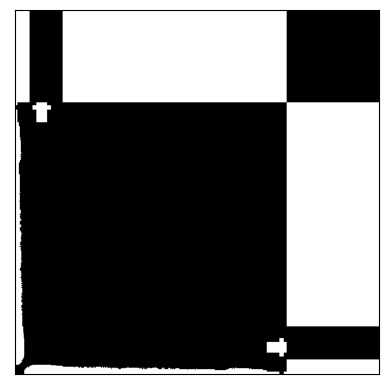

(1, 751, 751)


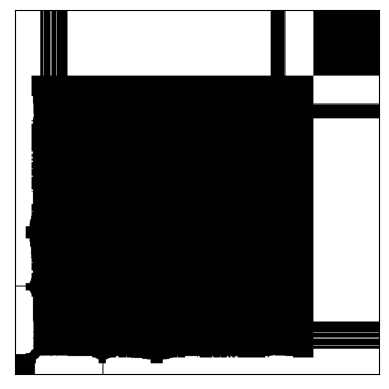

(1, 751, 751)


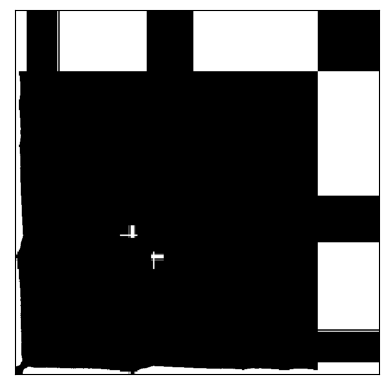

(1, 751, 751)


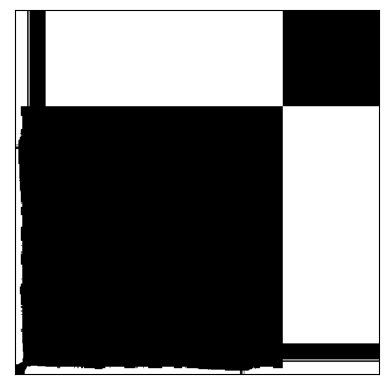

(1, 751, 751)


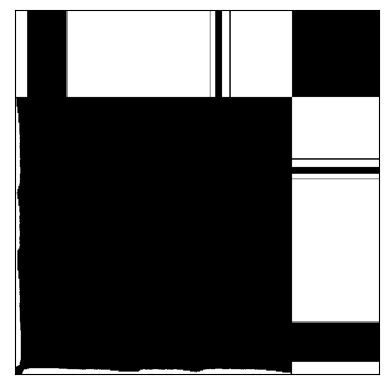

(1, 751, 751)


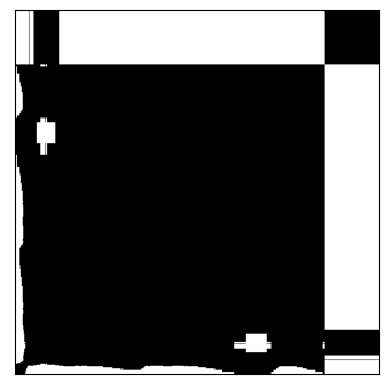

(1, 751, 751)


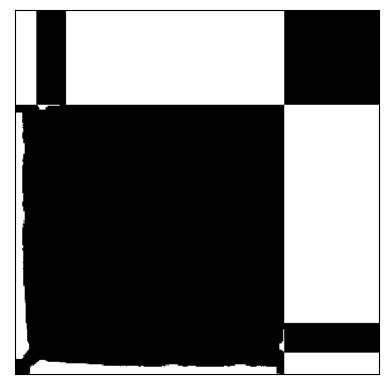

(1, 751, 751)


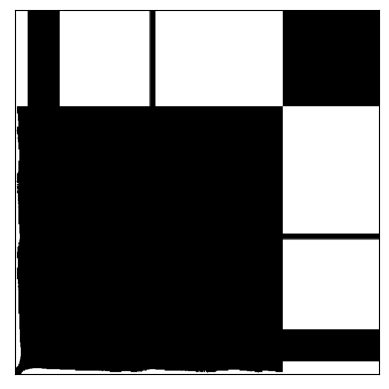

(1, 751, 751)


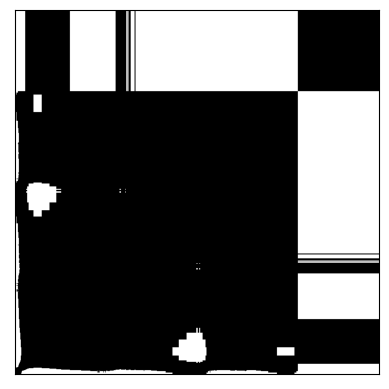

(1, 751, 751)


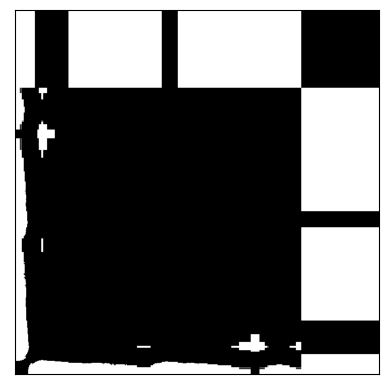

(1, 751, 751)


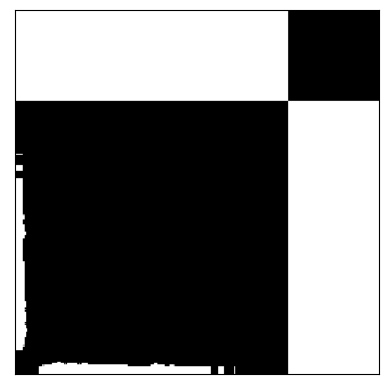

(1, 751, 751)


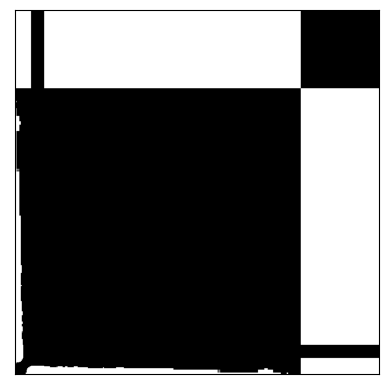

(1, 751, 751)


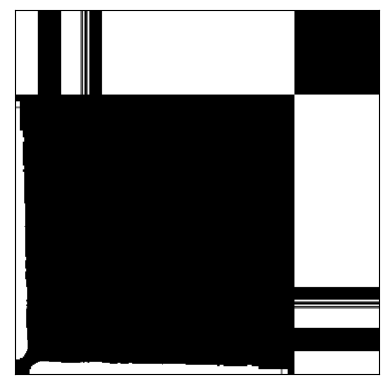

(1, 751, 751)


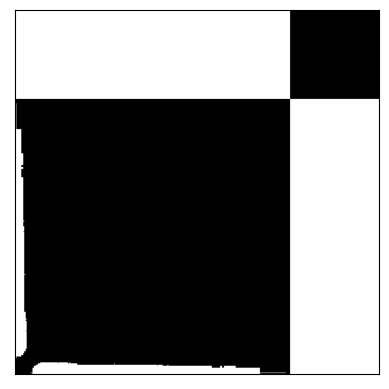

(1, 751, 751)


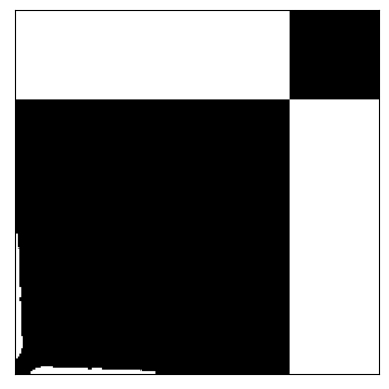

(1, 751, 751)


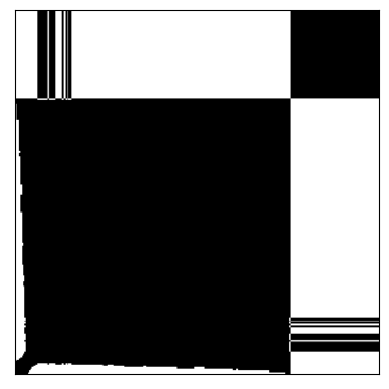

(1, 751, 751)


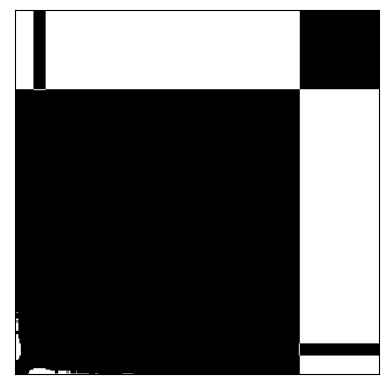

(1, 751, 751)


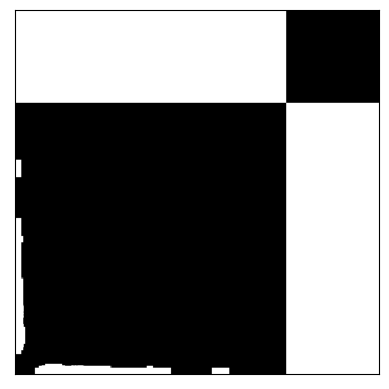

(1, 751, 751)


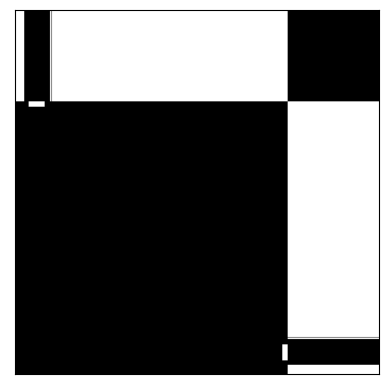

(1, 751, 751)


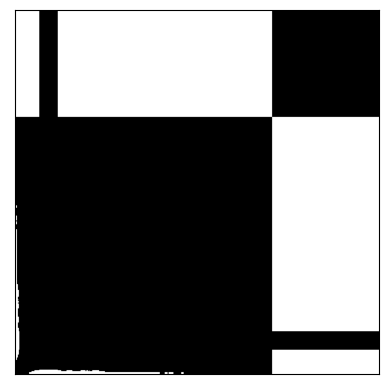

(1, 751, 751)


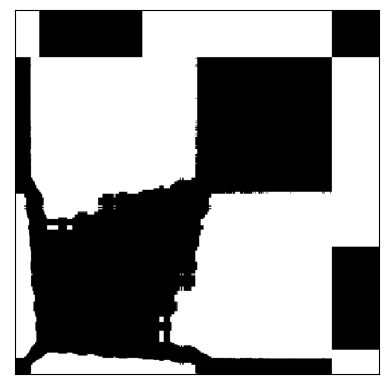

(1, 751, 751)


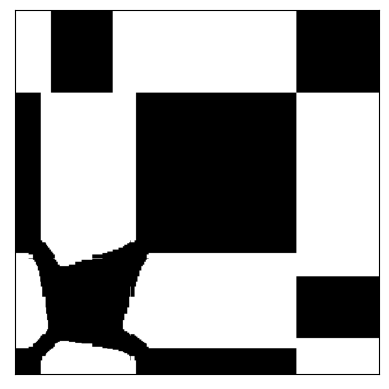

(1, 751, 751)


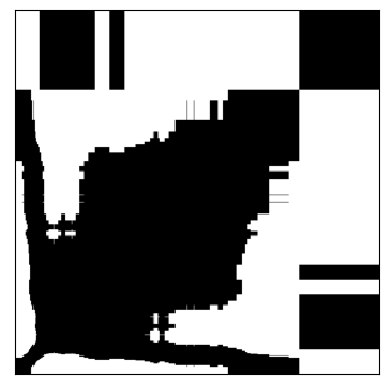

(1, 751, 751)


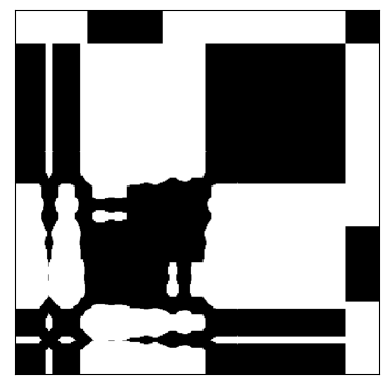

(1, 751, 751)


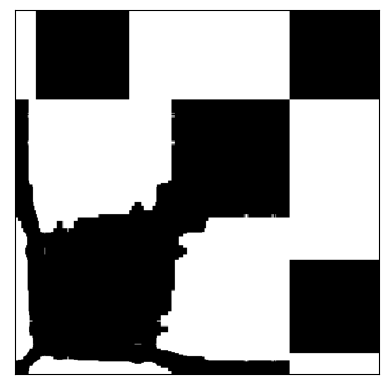

(1, 751, 751)


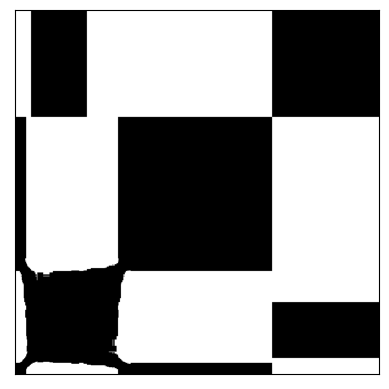

(1, 751, 751)


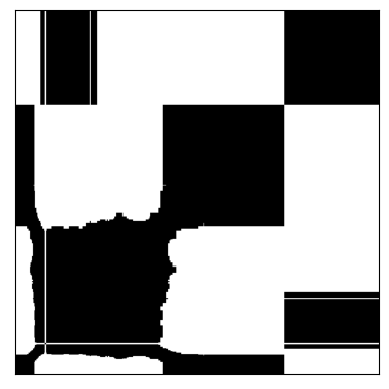

(1, 751, 751)


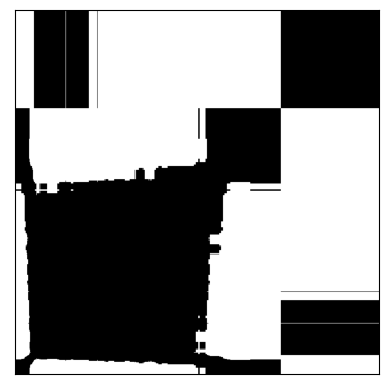

(1, 751, 751)


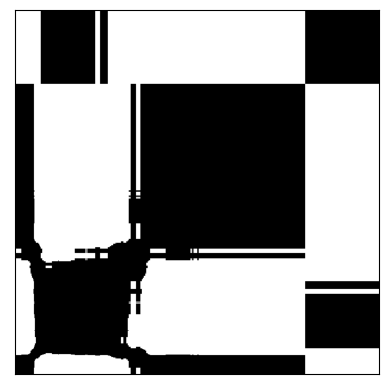

(1, 751, 751)


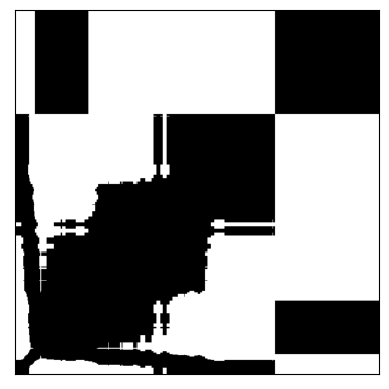

(1, 751, 751)


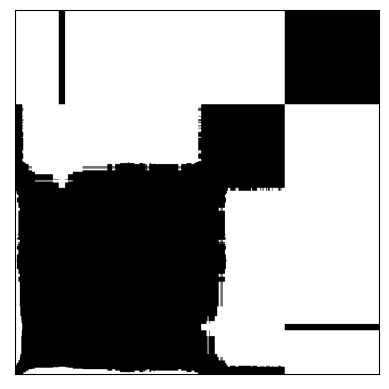

(1, 751, 751)


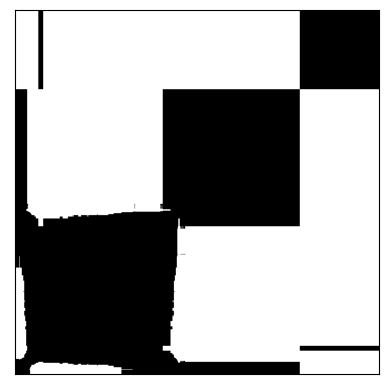

(1, 751, 751)


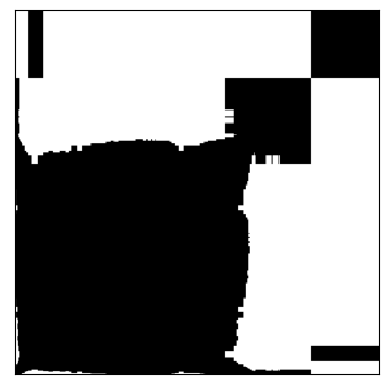

(1, 751, 751)


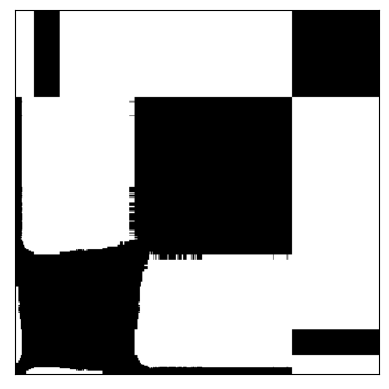

(1, 751, 751)


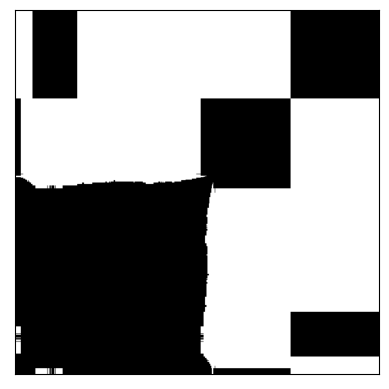

(1, 751, 751)


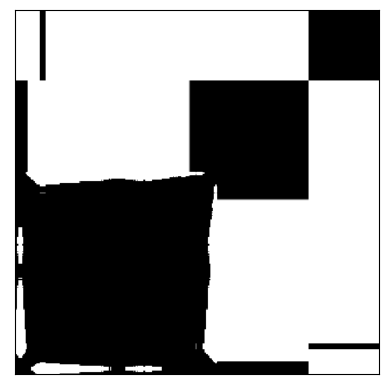

(1, 751, 751)


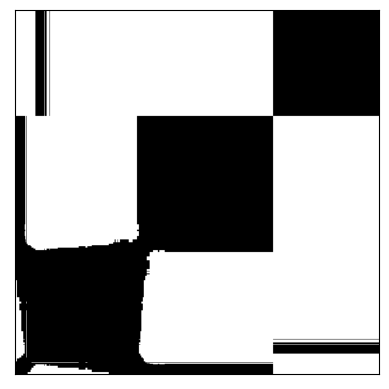

(1, 751, 751)


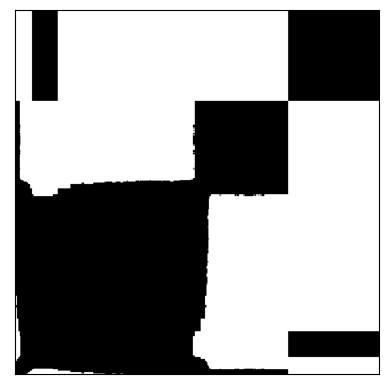

(1, 751, 751)


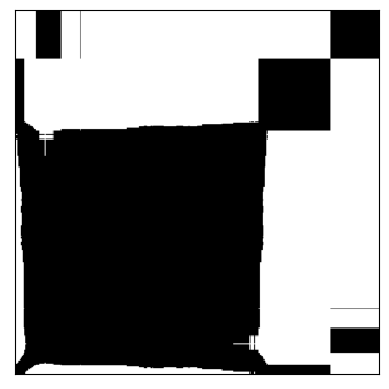

(1, 751, 751)


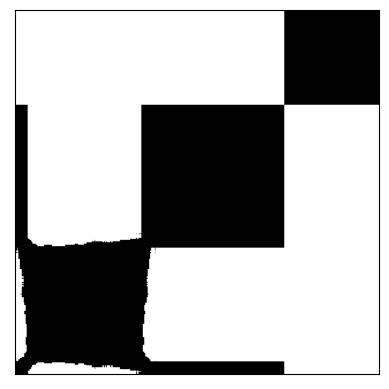

(1, 751, 751)


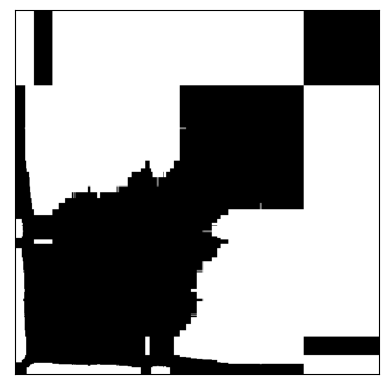

(1, 751, 751)


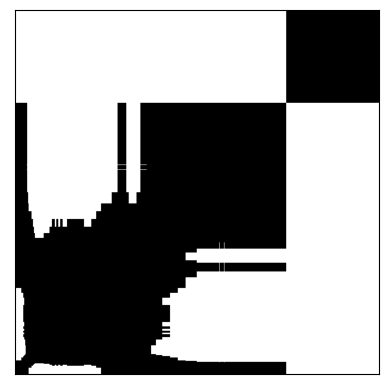

(1, 751, 751)


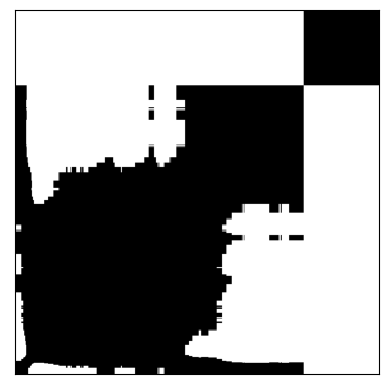

(1, 751, 751)


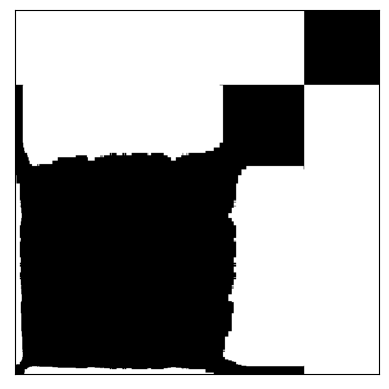

(1, 751, 751)


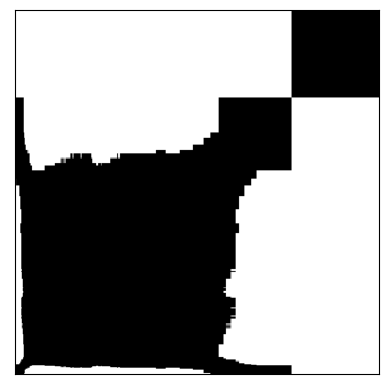

(1, 751, 751)


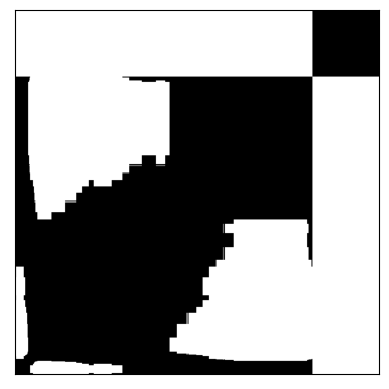

(1, 751, 751)


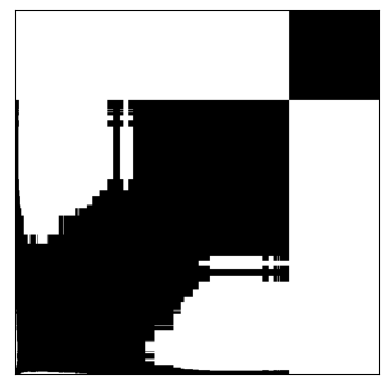

(1, 751, 751)


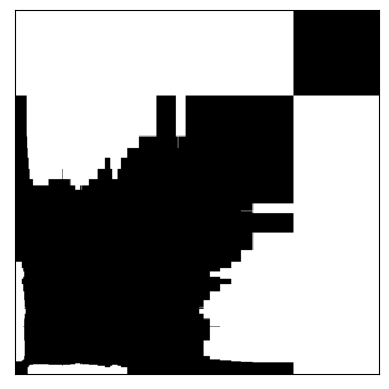

(1, 751, 751)


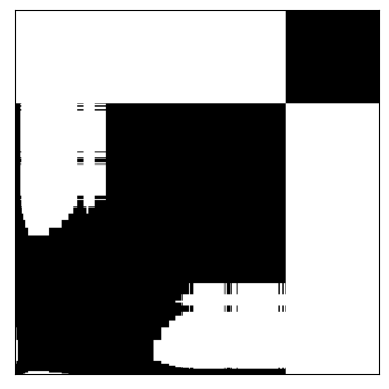

(1, 751, 751)


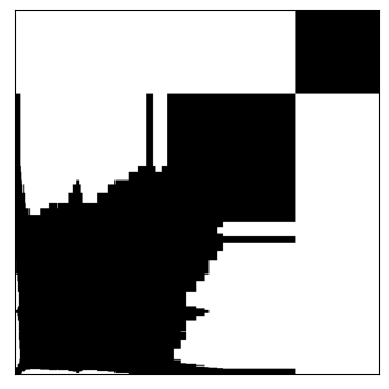

(1, 751, 751)


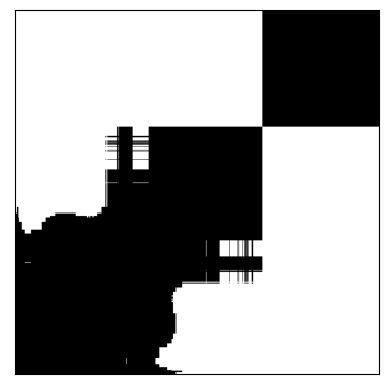

(1, 751, 751)


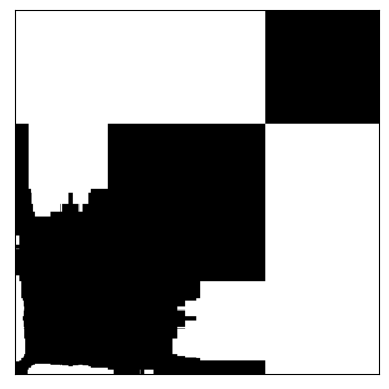

(1, 751, 751)


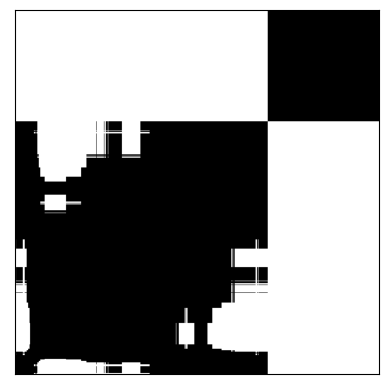

(1, 751, 751)


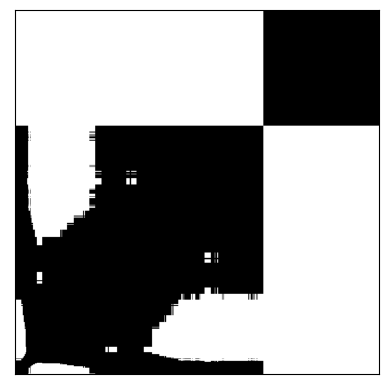

(1, 751, 751)


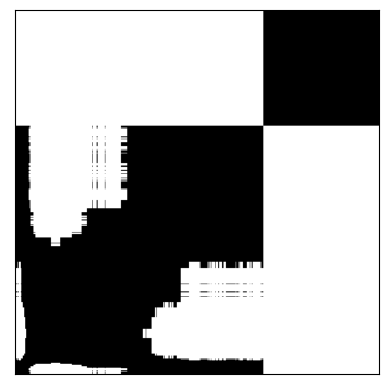

(1, 751, 751)


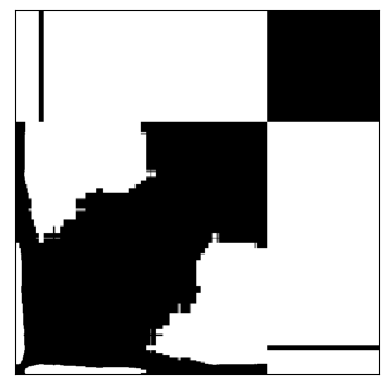

(1, 751, 751)


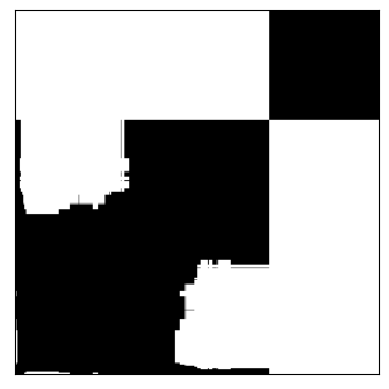

(1, 751, 751)


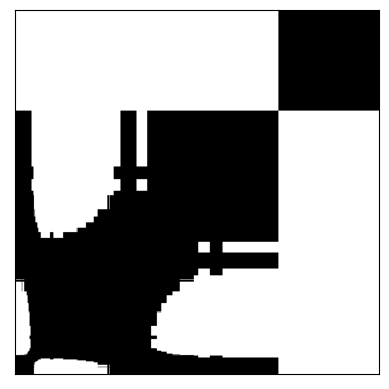

(1, 751, 751)


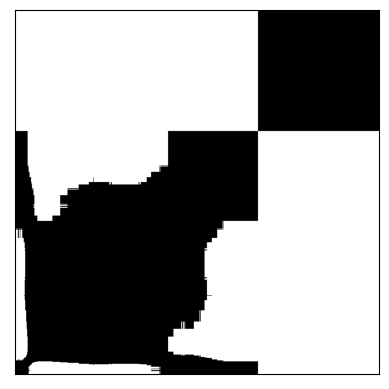

(1, 751, 751)


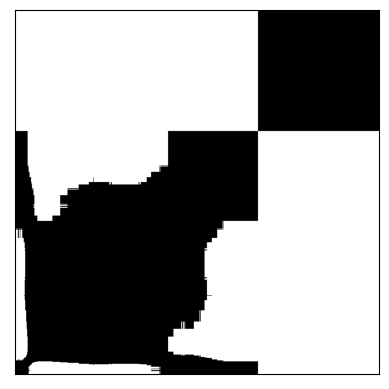

(1, 751, 751)


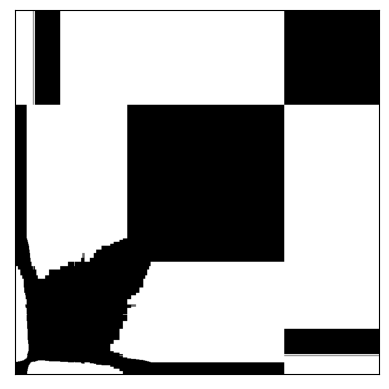

(1, 751, 751)


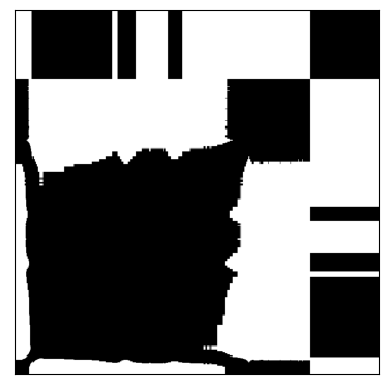

(1, 751, 751)


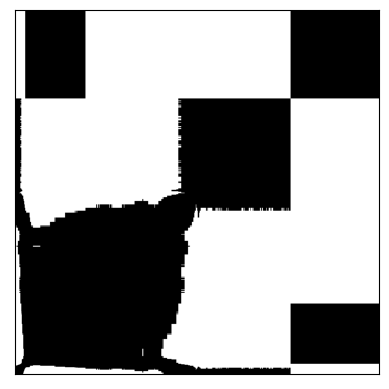

(1, 751, 751)


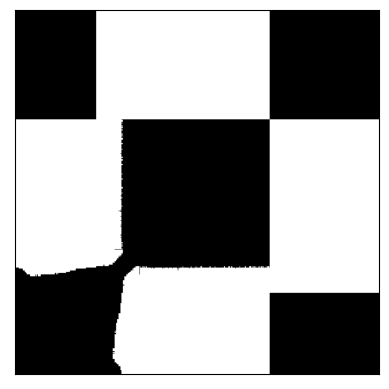

(1, 751, 751)


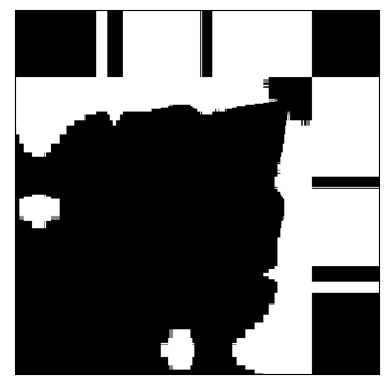

(1, 751, 751)


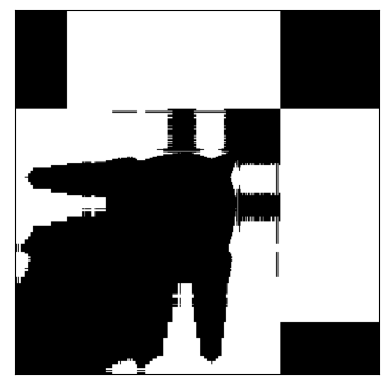

(1, 751, 751)


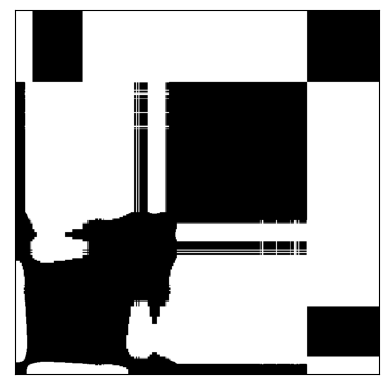

(1, 751, 751)


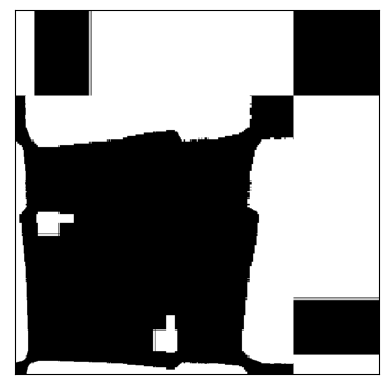

(1, 751, 751)


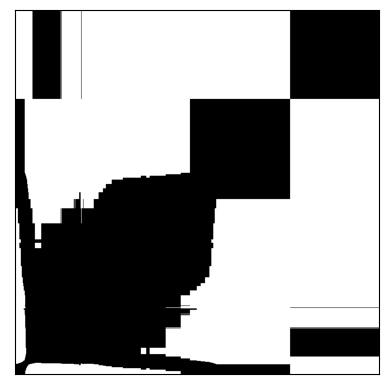

(1, 751, 751)


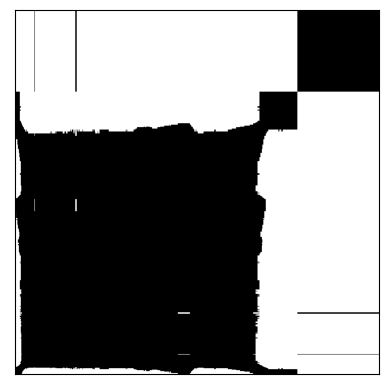

(1, 751, 751)


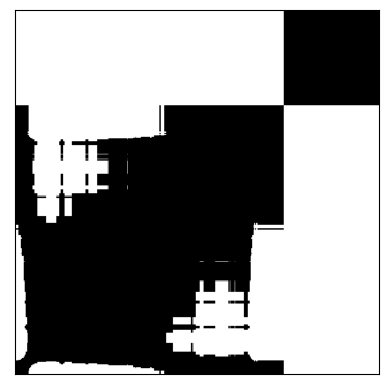

(1, 751, 751)


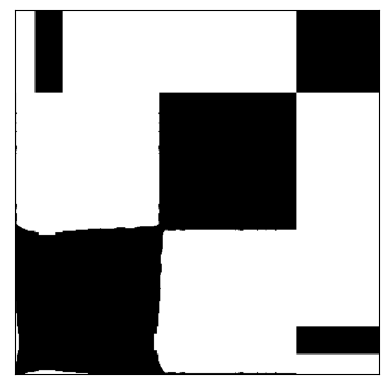

(1, 751, 751)


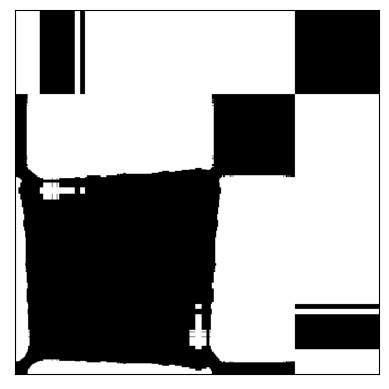

(1, 751, 751)


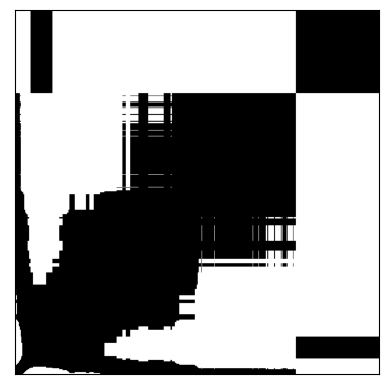

(1, 751, 751)


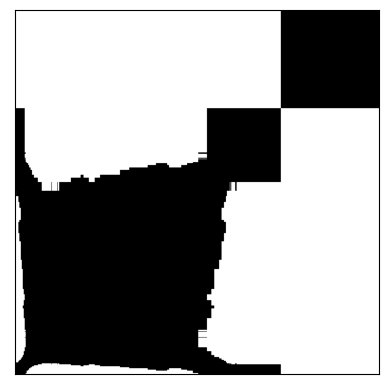

(1, 751, 751)


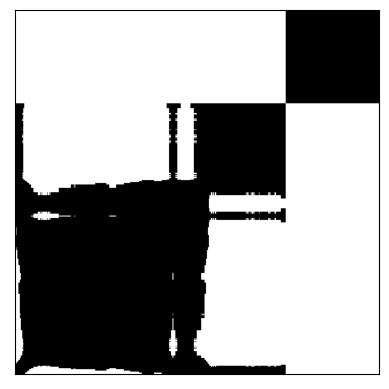

(1, 751, 751)


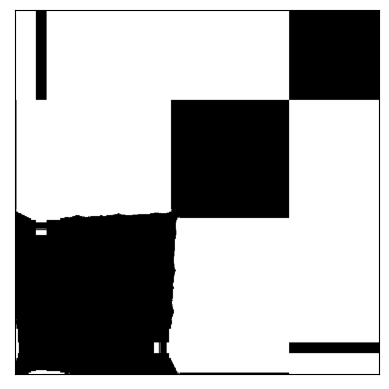

(1, 751, 751)


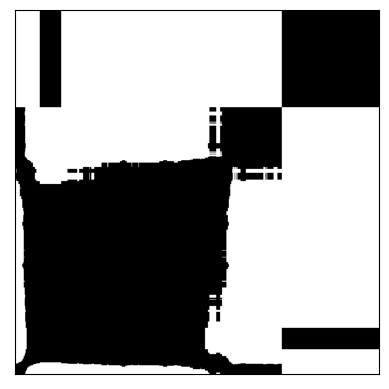

(1, 751, 751)


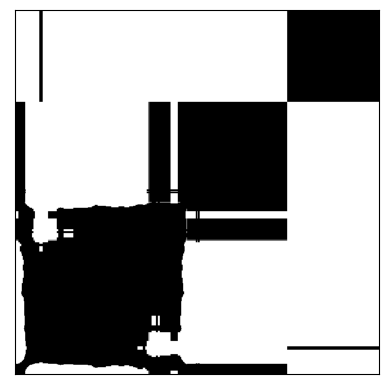

(1, 751, 751)


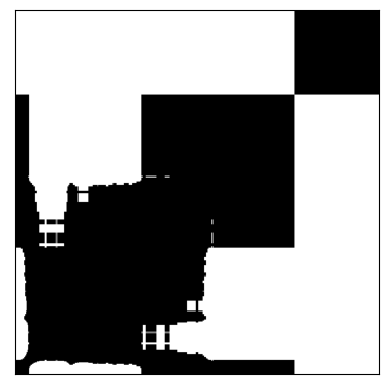

(1, 751, 751)


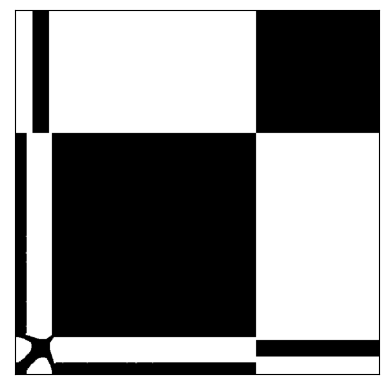

(1, 751, 751)


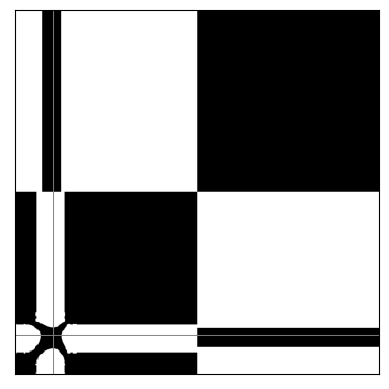

(1, 751, 751)


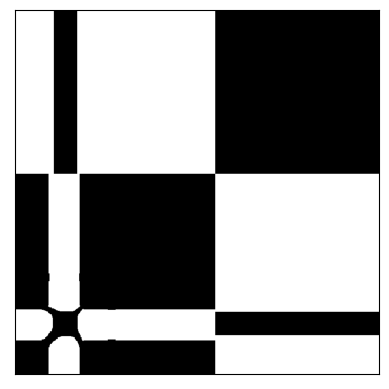

(1, 751, 751)


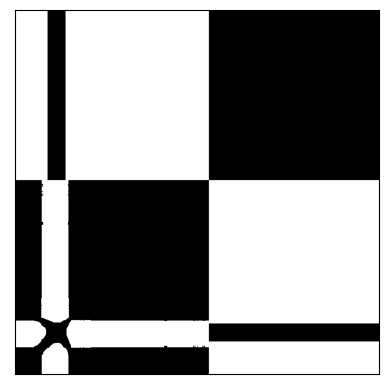

(1, 751, 751)


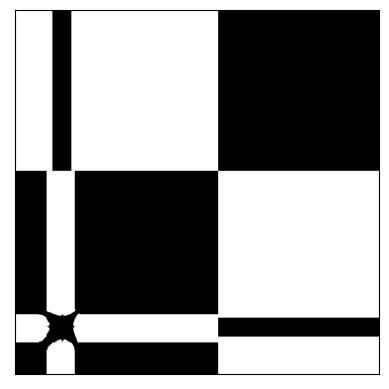

(1, 751, 751)


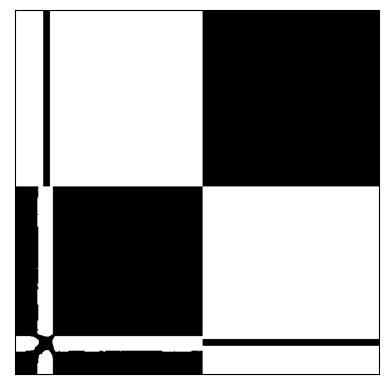

(1, 751, 751)


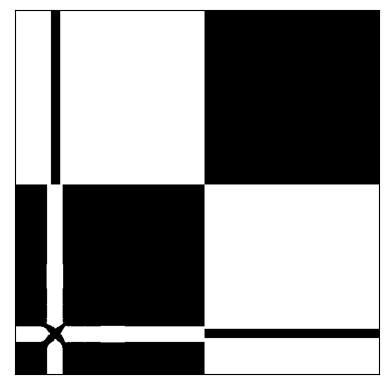

(1, 751, 751)


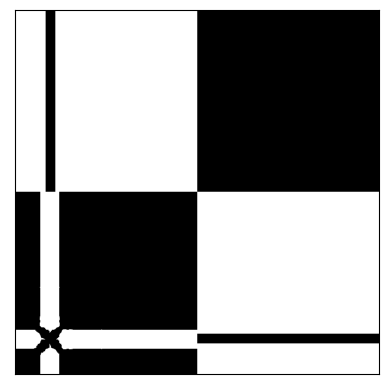

(1, 751, 751)


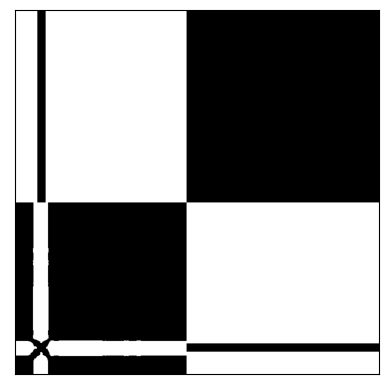

(1, 751, 751)


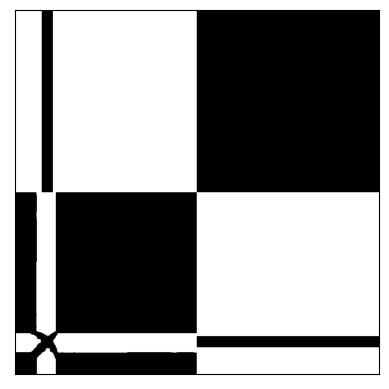

(1, 751, 751)


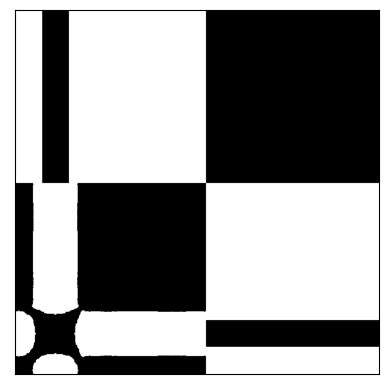

(1, 751, 751)


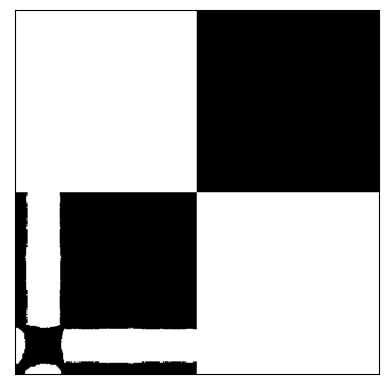

(1, 751, 751)


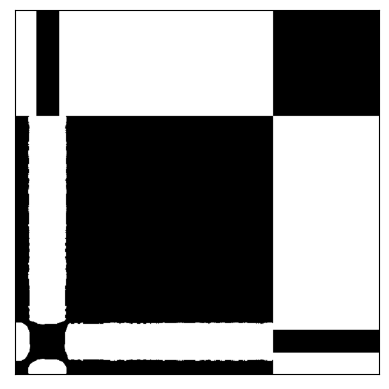

(1, 751, 751)


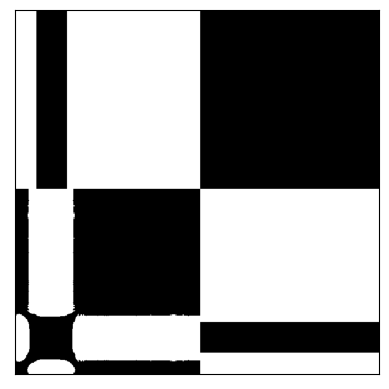

(1, 751, 751)


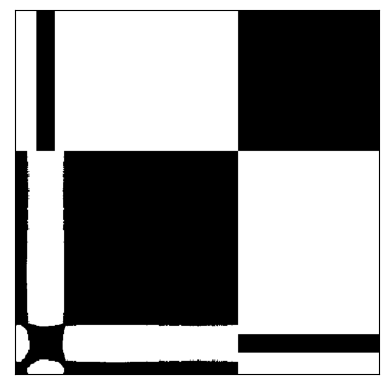

(1, 751, 751)


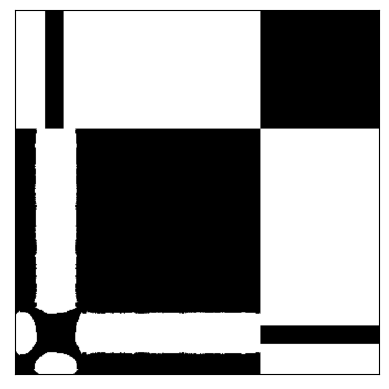

(1, 751, 751)


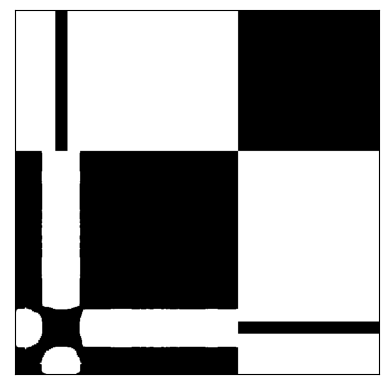

(1, 751, 751)


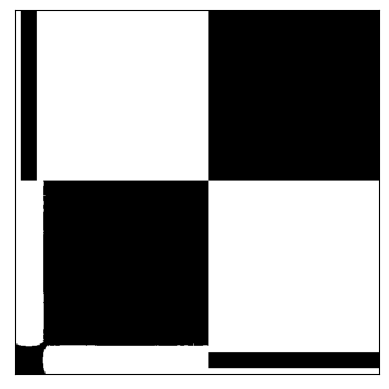

(1, 751, 751)


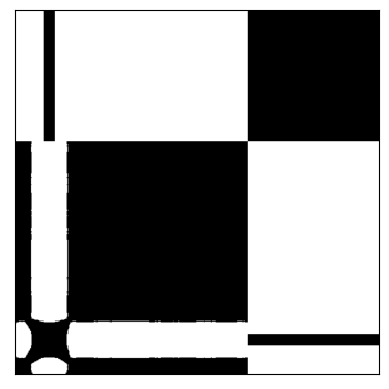

(1, 751, 751)


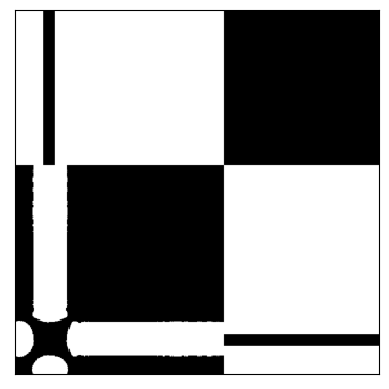

(1, 751, 751)


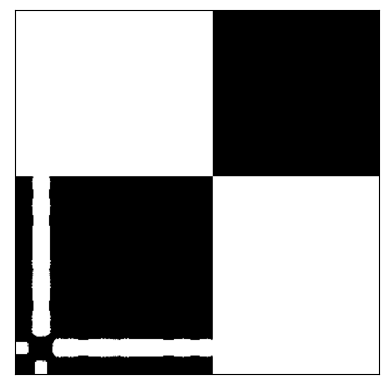

(1, 751, 751)


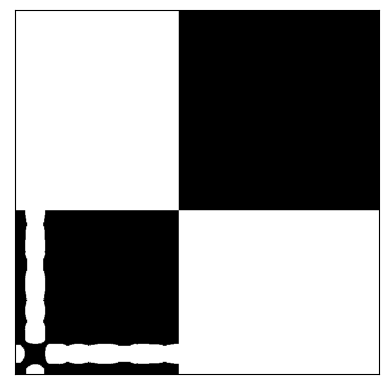

(1, 751, 751)


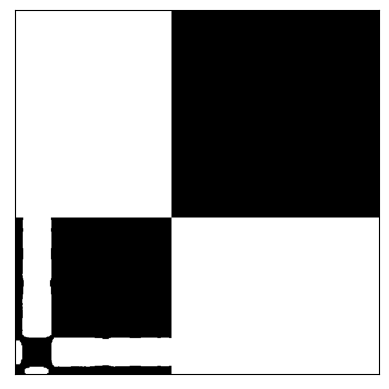

(1, 751, 751)


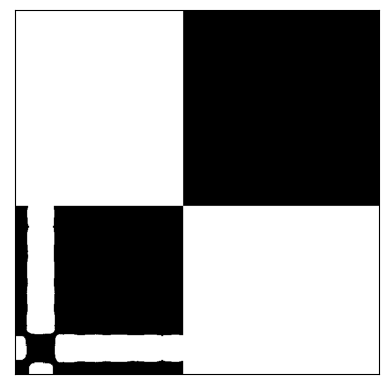

(1, 751, 751)


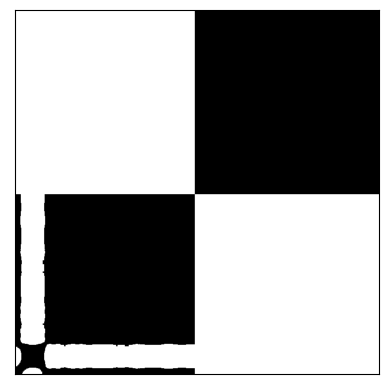

(1, 751, 751)


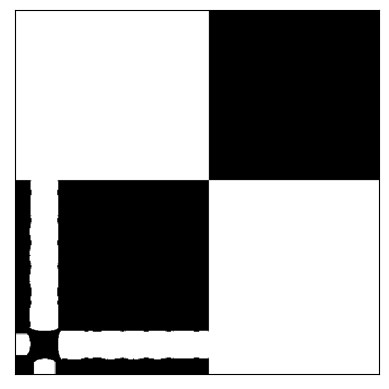

(1, 751, 751)


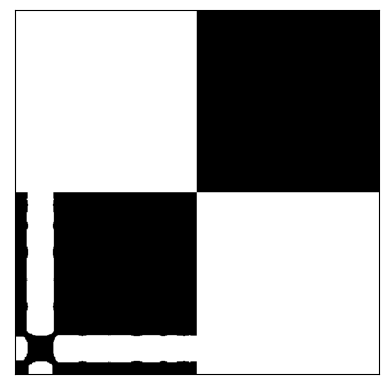

(1, 751, 751)


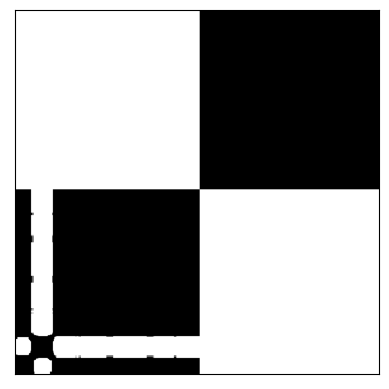

(1, 751, 751)


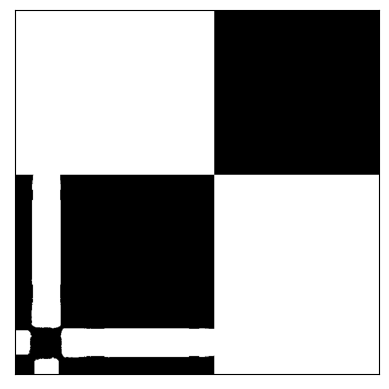

(1, 751, 751)


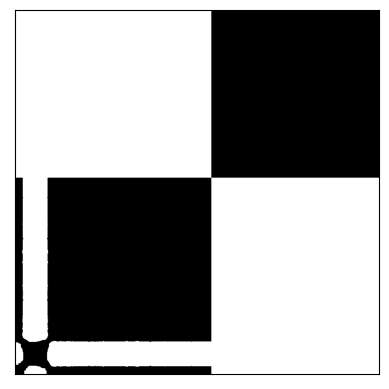

(1, 751, 751)


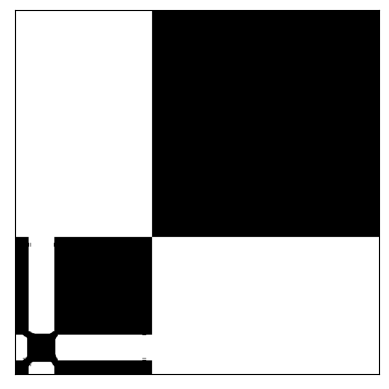

(1, 751, 751)


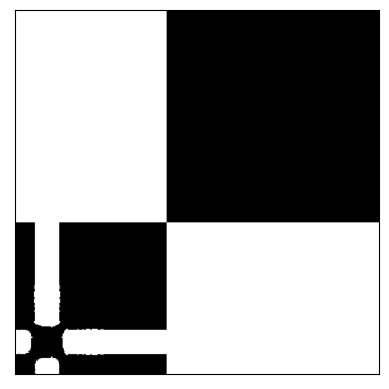

(1, 751, 751)


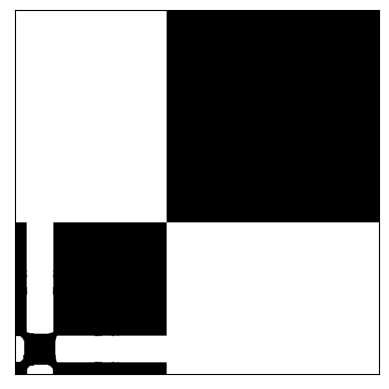

(1, 751, 751)


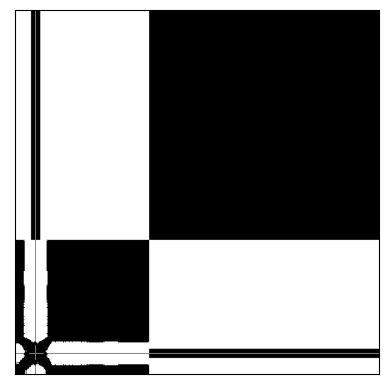

(1, 751, 751)


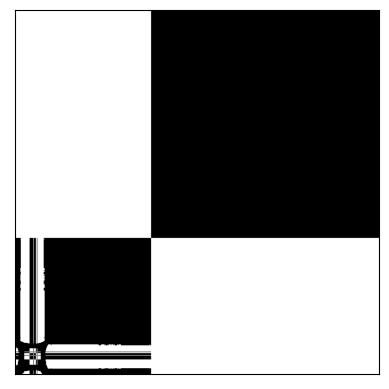

(1, 751, 751)


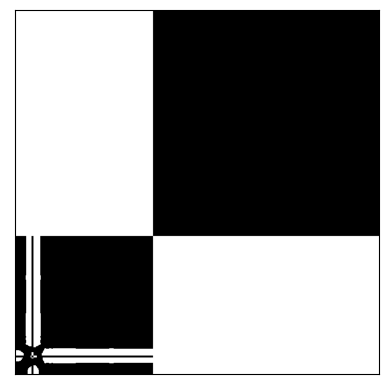

(1, 751, 751)


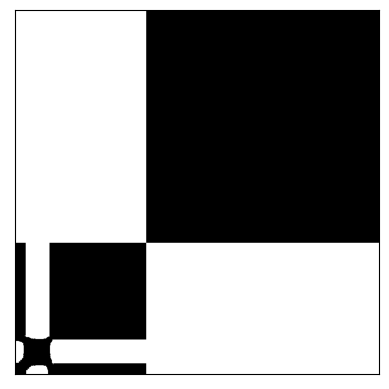

(1, 751, 751)


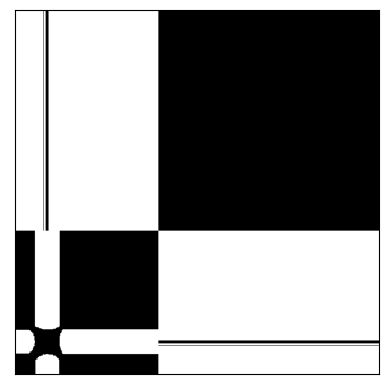

(1, 751, 751)


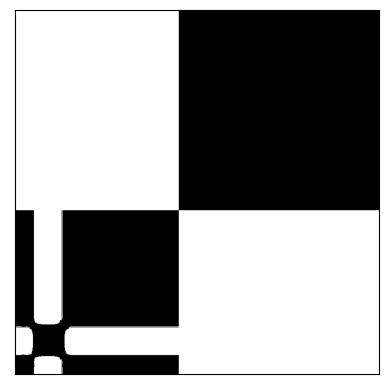

(1, 751, 751)


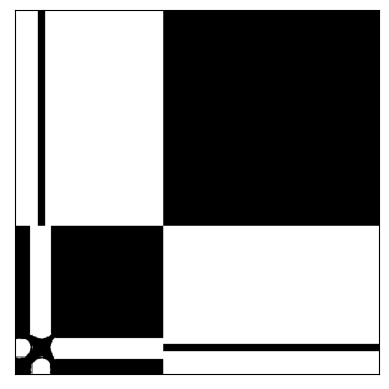

(1, 751, 751)


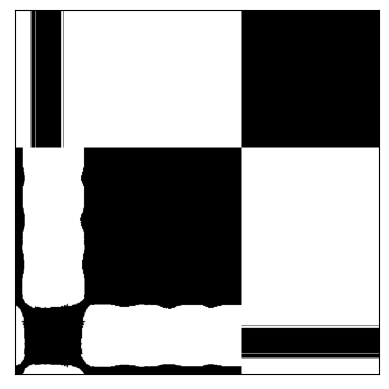

(1, 751, 751)


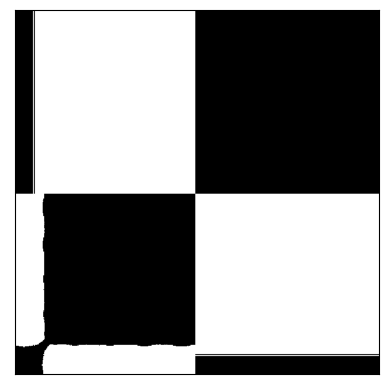

(1, 751, 751)


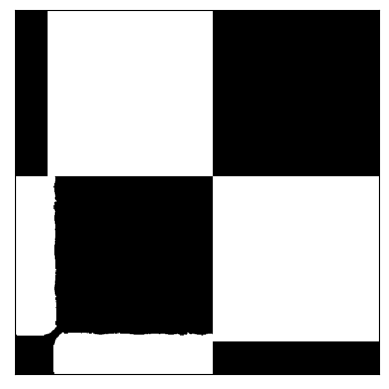

(1, 751, 751)


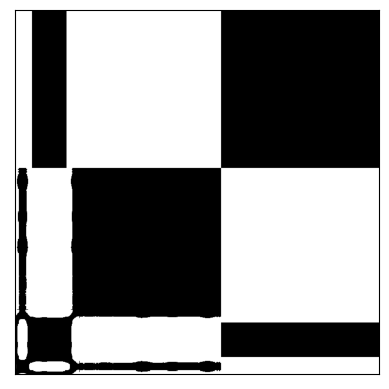

(1, 751, 751)


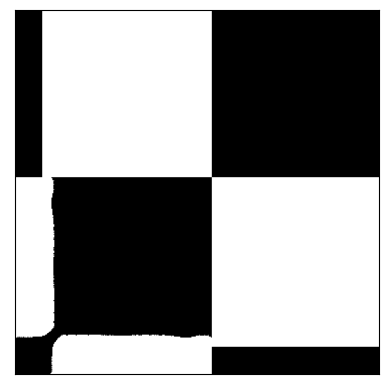

(1, 751, 751)


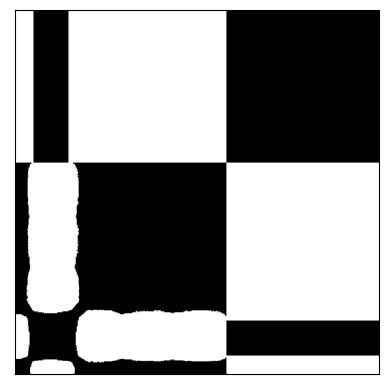

(1, 751, 751)


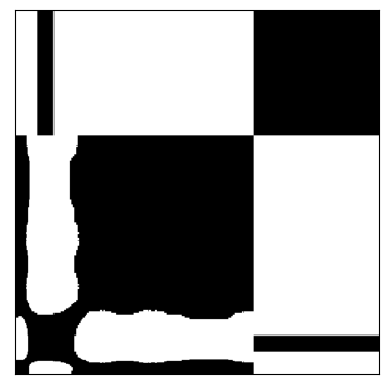

(1, 751, 751)


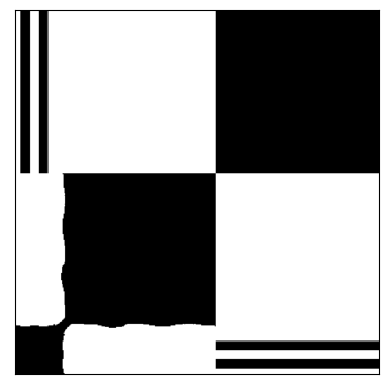

(1, 751, 751)


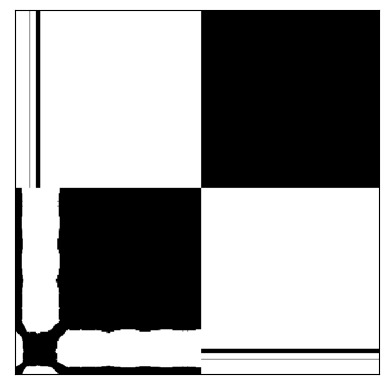

(1, 751, 751)


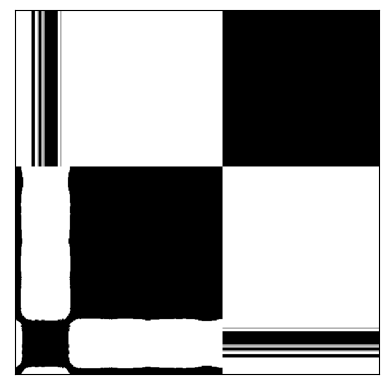

(1, 751, 751)


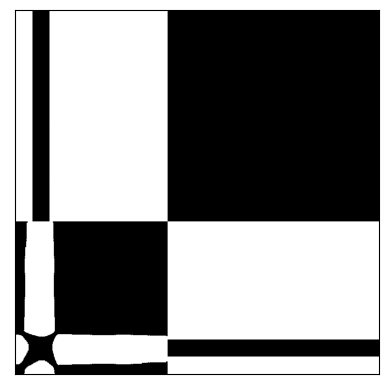

(1, 751, 751)


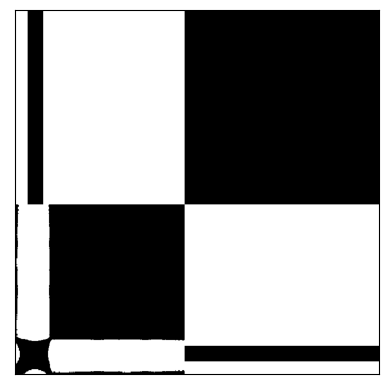

(1, 751, 751)


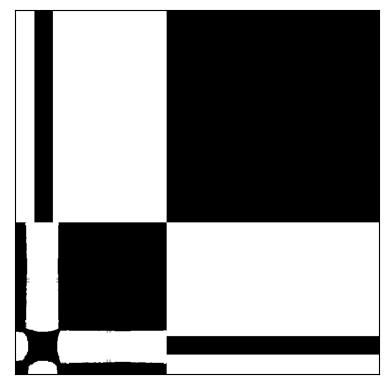

(1, 751, 751)


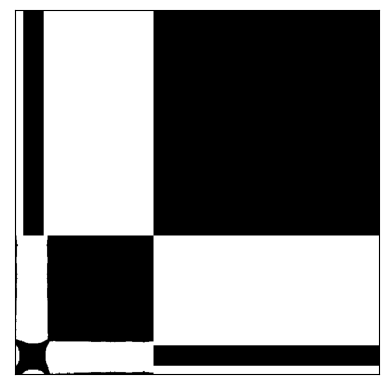

(1, 751, 751)


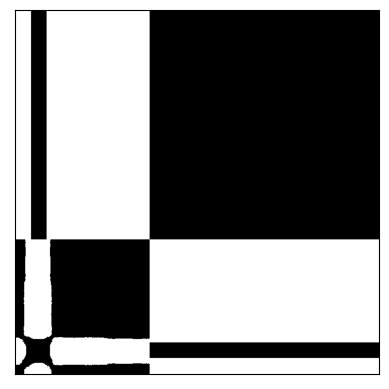

(1, 751, 751)


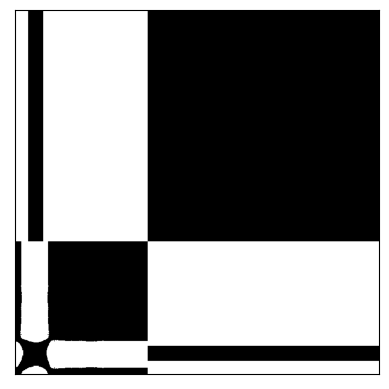

(1, 751, 751)


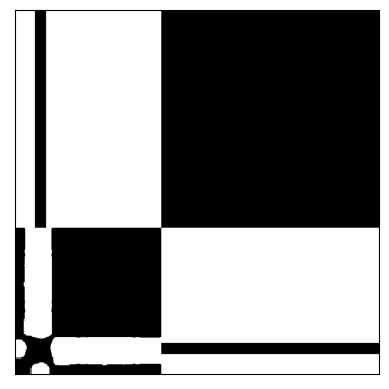

(1, 751, 751)


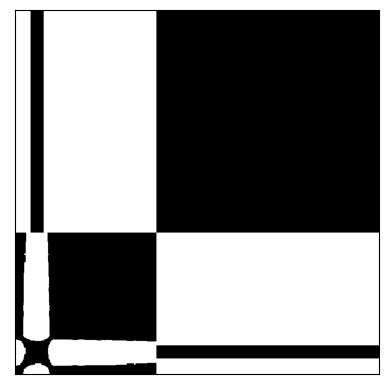

(1, 751, 751)


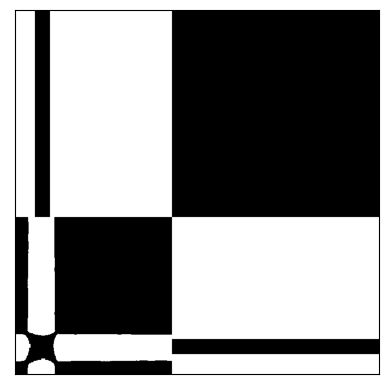

(1, 751, 751)


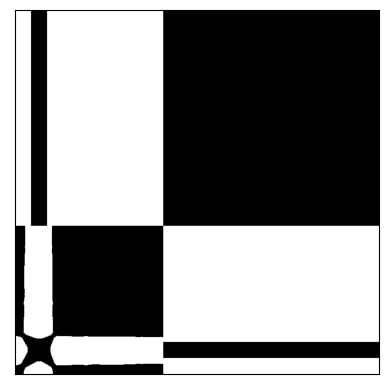

(1, 751, 751)


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from pyts.image import RecurrencePlot

y = np.linspace(0,751,751)

# Create a toy time series using the sine function
#time_points = np.linspace(0, 4 * np.pi, 1000)
#x = np.sin(time_points)

a = 30

x = vidcoordinates[a]

print(vidvalue[a])

X = np.array([x])

plt.xlabel('Frame')
plt.ylabel('Distans från toppen av videon')
plt.title('NIHSS-poäng: 0')
plt.plot(y, x, linewidth=2.0)

# Recurrence plot transformation

listofrp = []

for i in vidcoordinates:
    
    x = i
    X = np.array([x])
    rp = RecurrencePlot(threshold=np.pi/18)
    X_rp = rp.transform(X)

    # Plot the time series and its recurrence plot
    fig = plt.figure(figsize=(6, 6))

    gs = fig.add_gridspec(2, 2,  width_ratios=(2, 7), height_ratios=(2, 7),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)


    # Plot the recurrence plot on the bottom right
    ax_rp = fig.add_subplot(gs[1, 1])
    ax_rp.imshow(X_rp[0], cmap='binary', origin='lower',
                 extent=[0, 4 * np.pi, 0, 4 * np.pi])
    ax_rp.set_xticks([])
    ax_rp.set_yticks([])

    plt.show()

    X_rp2 = np.transpose(X_rp)
    print(X_rp.shape)
    
    listofrp.append(X_rp)

In [11]:
#Denna cell är själva neurala nätverket, så lägg in en till cell under som tar samma input men med annan ML-algoritm

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
import tensorflow as tf

import numpy as np

y = np.array(vidvaluebi)
X = np.array(vidcoordinates)



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
#X_train, X_test = X_train / 1080.0, X_test / 1080.0
print(X_train)
print(y_train)
#Gammalt

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)


model = tf.keras.models.Sequential([
  #tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train, y_train,
           batch_size=25,
           epochs=8,
           verbose=1,
           validation_data=(X_test, y_test))

model.evaluate(X_test, y_test)

[[0.5212963  0.5212963  0.5212963  ... 0.         0.         0.        ]
 [0.5212963  0.5212963  0.5212963  ... 0.         0.         0.        ]
 [0.5212963  0.54259259 0.5212963  ... 0.         0.         0.        ]
 ...
 [0.5212963  0.5212963  0.5        ... 0.         0.         0.        ]
 [0.58611111 0.58611111 0.58611111 ... 0.         0.         0.        ]
 [0.47777778 0.47777778 0.47777778 ... 0.         0.         0.        ]]
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1
 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1
 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0
 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1]
Epoch 1/8
8/8 [==============================] - 2s 57ms/step - loss: 0.9764 - accuracy: 0.6111 - val_loss: 0.5524 - val_accuracy: 0.7833
Epoch 2/8
8/8 [==============================] - 0s 

[0.2327500283718109, 0.8666666746139526]

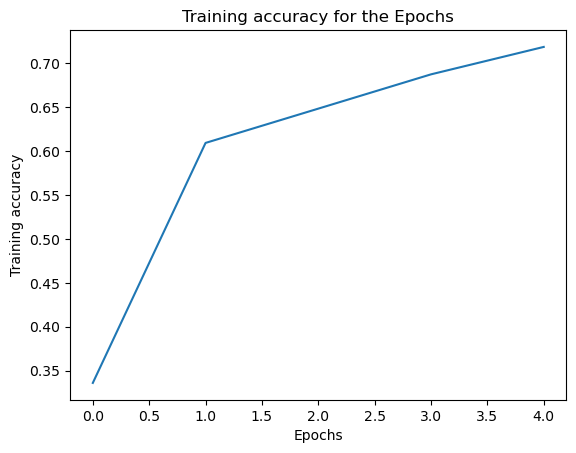

In [16]:
plt.plot(fit_info.history["accuracy"])
plt.title('Training accuracy for the Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training accuracy')

plt.show()

In [8]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

input_shape = (465, 930, 3)

# Define hyperparameters and their values for GridSearch
param_grid = {
    'learning_rate': [0.0001, 0.001],
    'hidden_layers': [1, 2],
}

combinations = [[0,0], [0,1], [1,0], [1,1]]

# Define hyperparameters and their values for GridSearch
param_grid2 = {
    'learning_rate': [0.0001, 0.001],
    'dropout_rate':  [0, 0.2],
    'hidden_layers': [1, 2],
}

combinations2 = [[0,0,0], [0,0,1], [0,1,0], [0,1,1], [1,0,0], [1,0,1], [1,1,0], [1,1,1]]

Sensitivity: 0.9574468085106383
Specificity: 0.6153846153846154
Confusion matrix, without normalization
[[ 8  5]
 [ 2 45]]


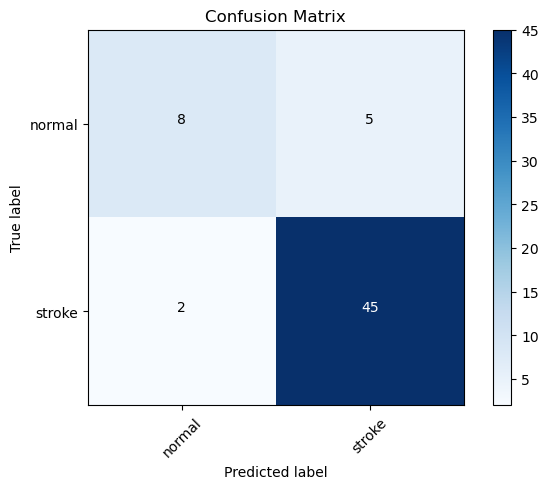

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

predictions = model.predict(x=X_test, verbose=0)
np.round(predictions)
cm = confusion_matrix(
    y_true=y_test, y_pred=np.argmax(predictions, axis=-1)
)

tn, fp, fn, tp = cm.ravel()

sensitivity = tp/(tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal","stroke"]
plot_confusion_matrix(cm=cm, classes = cm_plot_labels, title = "Confusion Matrix")


In [20]:
from sklearn import decomposition, svm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

rbf = svm.SVC(kernel='rbf', gamma=0.1, C=0.9).fit(X_train, y_train)
rbf_pred = rbf.predict(X_test)
svm_score = classification_report(y_test, rbf_pred)
rbf_accuracy = accuracy_score(y_test, rbf_pred)
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print(svm_score)

Accuracy (RBF Kernel):  93.33
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.81      0.93      0.87        14
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        19

    accuracy                           0.93        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.94      0.93      0.93        60



In [17]:
from keras.applications.resnet import ResNet152, ResNet50, ResNet101
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from keras.optimizers import Adam, SGD
from PIL import Image
from keras.layers import (
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    InputLayer,
    Activation,
    BatchNormalization,
    GlobalAveragePooling2D,
    Dropout,
    RandomFourierFeatures,
    Input,
)

param_grid = {
    'learning_rate': [0.0001, 0.001],
    'hidden_layers': [1, 2],
}
combinations = [[0,0], [0,1], [1,0], [1,1]]

#buffert = listofrp[0]
#listofrp[0] = listofrp[2]
#listofrp[2] = buffert

y_rp = np.array(vidvaluebi)
X_rp3 = np.array(listofrp)

# Resize images to 32x32
resized_images = []
for image in X_rp3:
    grayscale_image = image.squeeze(axis=0).astype('uint8')
    img = Image.fromarray(grayscale_image, mode='L')
    resized_img = img.resize((224,224))
    resized_np_img = np.array(resized_img)
    resized_images.append(resized_np_img)

# Convert the list of resized images back to NumPy array
X_rp_resized = np.array(resized_images)

# Reshape input data to match the model's input shape
X_rp_resized = np.expand_dims(X_rp_resized, axis=-1)

# Normalize the pixel values between 0 and 1
X_rp_resized = X_rp_resized.astype('float32')

# Update the input shape
input_shape = (224,224,1)

X_rp_train, X_rp_test, y_rp_train, y_rp_test = train_test_split(
    X_rp_resized, y_rp, test_size=0.25, random_state=42)
#X_train, X_test = X_train / 1080.0, X_test / 1080.0
print(X_rp_train)
print(y_rp_train)
#Gammalt

X_rp_train = tf.convert_to_tensor(X_rp_train, dtype=tf.float32)
y_rp_train = tf.convert_to_tensor(y_rp_train, dtype=tf.float32)

y_rp_test2 = y_rp_test

y_rp_train = to_categorical(y_rp_train, num_classes=2)
y_rp_test = to_categorical(y_rp_test, num_classes=2)

scores_resnet = []
models_resnet = []

for i in combinations:
    lr = param_grid['learning_rate'][i[0]]
    layers = param_grid['hidden_layers'][i[1]]
    print("Learning rate:", lr)
    print("Layers:", layers)

    # Create the base ResNet50 model
    base_model = ResNet152(weights=None, include_top=False, input_shape=input_shape)

    # Add a global average pooling layer and a dense layer with softmax activation for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    for i in range(layers):
        x = Dense(128, activation="relu")(x)
    predictions = Dense(2, activation="softmax")(x)

    # Define the model to be trained with the ResNet50 base and the classification layers added
    model_resnet = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base ResNet50 layers so they are not updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with a learning rate of 0.001 and a categorical cross-entropy loss function
    model_resnet.compile(
        optimizer=Adam(lr=lr), loss="categorical_crossentropy", metrics=["accuracy"]
    )

    model_resnet.fit(X_rp_train, y_rp_train,
           batch_size=25,
           epochs=3,
           verbose=1,
           validation_data=(X_rp_test, y_rp_test))
    score = model_resnet.evaluate(X_rp_test,y_rp_test, verbose=0)

    print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))
    
    scores_resnet.append(score)
    models_resnet.append(model_resnet)

print(scores_resnet)

[[[[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[0.

In [15]:
from keras.applications.resnet import ResNet152, ResNet50, ResNet101
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from keras.optimizers import Adam, SGD
from PIL import Image
from keras.layers import (
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    InputLayer,
    Activation,
    BatchNormalization,
    GlobalAveragePooling2D,
    Dropout,
    RandomFourierFeatures,
    Input,
)

param_grid = {
    'learning_rate': [0.0001, 0.001],
    'hidden_layers': [1, 2],
}
combinations = [[0,0], [0,1], [1,0], [1,1]]

#buffert = listofrp[0]
#listofrp[0] = listofrp[2]
#listofrp[2] = buffert

y_rp = np.array(vidvalue)
X_rp3 = np.array(listofrp)

# Resize images to 32x32
resized_images = []
for image in X_rp3:
    grayscale_image = image.squeeze(axis=0).astype('uint8')
    img = Image.fromarray(grayscale_image, mode='L')
    resized_img = img.resize((224,224))
    resized_np_img = np.array(resized_img)
    resized_images.append(resized_np_img)

# Convert the list of resized images back to NumPy array
X_rp_resized = np.array(resized_images)

# Reshape input data to match the model's input shape
X_rp_resized = np.expand_dims(X_rp_resized, axis=-1)

# Normalize the pixel values between 0 and 1
X_rp_resized = X_rp_resized.astype('float32')

# Update the input shape
input_shape = (224,224,1)

X_rp_train, X_rp_test, y_rp_train, y_rp_test = train_test_split(
    X_rp_resized, y_rp, test_size=0.25, random_state=42)
#X_train, X_test = X_train / 1080.0, X_test / 1080.0
print(X_rp_train)
print(y_rp_train)
#Gammalt

X_rp_train = tf.convert_to_tensor(X_rp_train, dtype=tf.float32)
y_rp_train = tf.convert_to_tensor(y_rp_train, dtype=tf.float32)

y_rp_test2 = y_rp_test

y_rp_train = to_categorical(y_rp_train, num_classes=2)
y_rp_test = to_categorical(y_rp_test, num_classes=2)

scores_resnet = []
models_resnet = []

for i in combinations:
    lr = param_grid['learning_rate'][i[0]]
    layers = param_grid['hidden_layers'][i[1]]
    print("Learning rate:", lr)
    print("Layers:", layers)

    # Create the base ResNet50 model
    base_model = ResNet152(weights=None, include_top=False, input_shape=input_shape)

    # Add a global average pooling layer and a dense layer with softmax activation for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    for i in range(layers):
        x = Dense(128, activation="relu")(x)
    predictions = Dense(2, activation="softmax")(x)

    # Define the model to be trained with the ResNet50 base and the classification layers added
    model_resnet = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base ResNet50 layers so they are not updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with a learning rate of 0.001 and a categorical cross-entropy loss function
    model_resnet.compile(
        optimizer=Adam(lr=lr), loss="categorical_crossentropy", metrics=["accuracy"]
    )

    model_resnet.fit(X_rp_train, y_rp_train,
           batch_size=25,
           epochs=3,
           verbose=1,
           validation_data=(X_rp_test, y_rp_test))
    score = model_resnet.evaluate(X_rp_test,y_rp_test, verbose=0)

    print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))
    
    scores_resnet.append(score)
    models_resnet.append(model_resnet)

print(scores_resnet)

[[[[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[0.]
   [0.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[0.

IndexError: index 2 is out of bounds for axis 1 with size 2

Sensitivity: 1.0
Specificity: 0.0
Confusion matrix, without normalization
[[ 0 13]
 [ 0 47]]


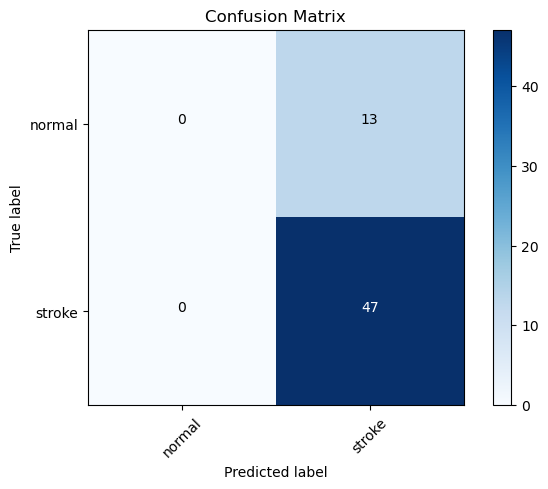

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

predictions = models_resnet[3].predict(x=X_rp_test, verbose=0)
np.round(predictions)
cm = confusion_matrix(
    y_true=y_rp_test2, y_pred=np.argmax(predictions,axis=-1)
)

tn, fp, fn, tp = cm.ravel()

sensitivity = tp/(tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal","stroke"]
plot_confusion_matrix(cm=cm, classes = cm_plot_labels, title = "Confusion Matrix")
